# Анализ бизнес показателей.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# 1. Описание проекта

Вы — маркетинговый аналитик **развлекательного приложения Procrastinate Pro+**. 

**Проблема**: Несмотря на огромные вложения в рекламу, `последние несколько месяцев компания терпит убытки`. 

**Ваша задача** — разобраться в причинах и помочь компании выйти в плюс.

Есть **данные** о пользователях, привлечённых с `1 мая по 27 октября 2019 года`:

    •	лог сервера с данными об их посещениях,
    •	выгрузка их покупок за этот период,
    •	рекламные расходы.

Вам предстоит изучить:

    •	откуда приходят пользователи и какими устройствами они пользуются,
    •	сколько стоит привлечение пользователей из различных рекламных каналов;
    •	сколько денег приносит каждый клиент,
    •	когда расходы на привлечение клиента окупаются,
    •	какие факторы мешают привлечению клиентов.
    
    
Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

**Описание данных**

В вашем распоряжении три датасета. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

Структура `visits_info_short.csv`:

    •	User Id — уникальный идентификатор пользователя,
    •	Region — страна пользователя,
    •	Device — тип устройства пользователя,
    •	Channel — идентификатор источника перехода,
    •	Session Start — дата и время начала сессии,
    •	Session End — дата и время окончания сессии.

Структура `orders_info_short.csv`:

    •	User Id — уникальный идентификатор пользователя,
    •	Event Dt — дата и время покупки,
    •	Revenue — сумма заказа.

Структура `costs_info_short.csv`:

    •	dt — дата проведения рекламной кампании,
    •	Channel — идентификатор рекламного источника,
    •	costs — расходы на эту кампанию.


# 2. Подготовка данных к анализу

In [3]:
try:
    visits = pd.read_csv(r'/Jupyter/datasets/visits_info_short.csv')  # журнал сессий
    orders = pd.read_csv(r'/Jupyter/datasets/orders_info_short.csv')  # покупки
    costs = pd.read_csv(r'/Jupyter/datasets/costs_info_short.csv')  # траты на рекламу
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')  # журнал сессий
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')  # покупки
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')  # траты на рекламу

In [4]:
display(visits.head())
display(orders.head())
costs.head()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [5]:
[print(i.info(), end='\n\n------------------------------------\n\n') for i in (visits, orders, costs)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None

------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

------------------------------------

<class 'pandas.core.frame.DataFr

[None, None, None]

In [6]:
dictt = {'visits': visits, 'orders': orders, 'costs': costs}
[print(f'sum_dupli data {i} - {dictt[i].duplicated().sum()}', end='\n\n') for i in dictt.keys()]

sum_dupli data visits - 0

sum_dupli data orders - 0

sum_dupli data costs - 0



[None, None, None]

- Явные дубликаты отсутствуют.
- Пропуски отсутствуют.
- Тип значения дат привести к типу datetime.
- Названия колонок привести к типу_типа.
- Строковые значения привести к нижнему регистру.

In [7]:
# Названия колонок привести к типу_типа.
visits.columns = [i.replace(' ', '_').lower() for i in visits.columns]
orders.columns = [i.replace(' ', '_').lower() for i in orders.columns]
costs.columns = [i.replace(' ', '_').lower() for i in costs.columns]

[print(f'columns {i} - {dictt[i].columns}', end='\n\n') for i in dictt.keys()]

columns visits - Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

columns orders - Index(['user_id', 'event_dt', 'revenue'], dtype='object')

columns costs - Index(['dt', 'channel', 'costs'], dtype='object')



[None, None, None]

In [8]:
# Строковые значения привести к нижнему регистру.

visits.region = visits.region.str.lower()
visits.device = visits.device.str.lower()
visits.channel = visits.channel.str.lower()

costs.channel = costs.channel.str.lower()

In [9]:
[print(f'sum_dupli data {i} - {dictt[i].duplicated().sum()}', end='\n\n') for i in dictt.keys()]

sum_dupli data visits - 0

sum_dupli data orders - 0

sum_dupli data costs - 0



[None, None, None]

Проверка строковых значений на неявные дубли.

In [10]:
costs.channel.unique()

array(['faceboom', 'mediatornado', 'rocketsuperads', 'tiptop', 'yrabbit',
       'adnonsense', 'leapbob', 'opplecreativemedia', 'wahoonetbanner',
       'lambdamediaads'], dtype=object)

In [11]:
visits.region.unique()

array(['united states', 'uk', 'france', 'germany'], dtype=object)

In [12]:
visits.device.unique()

array(['iphone', 'mac', 'android', 'pc'], dtype=object)

In [13]:
visits.channel.unique()

array(['organic', 'tiptop', 'rocketsuperads', 'yrabbit', 'faceboom',
       'mediatornado', 'adnonsense', 'leapbob', 'wahoonetbanner',
       'opplecreativemedia', 'lambdamediaads'], dtype=object)

In [14]:
#Тип значения дат привести к типу datetime

visits['session_start'] = pd.to_datetime(visits['session_start']) 
visits['session_end'] = pd.to_datetime(visits['session_end']) 
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

**Итоги предподготовки данных:**

- **В ходе предобработки данных пропуски, дубликаты не были выявлены.**
- **Названия колонок были привелены к стилю snake_case**
- **Строковые данные приведены к нижнему регистру.**
- **Столбцы с датами приведены к типу datetime.**

# 3. Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [15]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [16]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [17]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [18]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [19]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [20]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [21]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [22]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

# 4. Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

### 4.1. Составление профилей пользователей. Определение минимальной и максимальной даты привлечения пользователей.

Получим профили пользователей. Для этого вызовем функцию `get_profiles()`, передав ей данные о посещениях, покупках и тратах на рекламу развлекательного приложения `Procrastinate Pro+`.

In [23]:
# других событий нет, None — чтобы не «сломать» get_profiles()
events = None 

profiles = get_profiles(visits, orders, events, costs)
profiles.head(5)

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    faceboom     mac  united states   
1   4919697 2019-07-09 12:46:07    faceboom  iphone  united states   
2   6085896 2019-10-01 09:58:33     organic  iphone         france   
3  22593348 2019-08-22 21:35:48  adnonsense      pc        germany   
4  31989216 2019-10-02 00:07:44     yrabbit  iphone  united states   

           dt               month  payer  acquisition_cost  
0  2019-05-07 2019-05-07 20:58:57   True          1.088172  
1  2019-07-09 2019-07-09 12:46:07  False          1.107237  
2  2019-10-01 2019-10-01 09:58:33  False          0.000000  
3  2019-08-22 2019-08-22 21:35:48  False          0.988235  
4  2019-10-02 2019-10-02 00:07:44  False          0.230769

In [24]:
min_analysis_date = profiles['dt'].min()
max_analysis_date = profiles['dt'].max()
print(f'Минимальная дата привлечения пользователей {min_analysis_date}\
\nМаксимальная дата привлечения пользователей {max_analysis_date}')

Минимальная дата привлечения пользователей 2019-05-01
Максимальная дата привлечения пользователей 2019-10-27


In [25]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

### 4.2. Определение из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построение таблицы, которая отражаюет количество пользователей и долю платящих из каждой страны.

In [26]:
# а почему бы и нет, ведь будет три разбиения.
def return_table_and_plot(data, groupby, group_name='group_name', byby='payer'):
    table = data.pivot_table(index=groupby, values='payer', 
                         aggfunc=['count', 'sum', lambda x: round(100 * x.sum() / x.count(), 2)]).reset_index()
    table.columns = [group_name, 'user_all', 'payer', 'ratio_payer']
    table['ratio_payer_all'] = round(100 *table['payer'] / table['payer'].sum(), 2)
    table = table.sort_values(by=byby, ascending=False).reset_index(drop=True)
    table.index = table[groupby].reset_index(drop=True)
    del table[groupby]

    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))

    table.plot(kind='pie', y='user_all', legend=False,
               title='Доля когорты от всех пользователей', autopct='%1.1f%%', ax=ax1, ylabel='');

    table.plot(kind='pie', y='payer', legend=False,
               title='Доля когорты от всех платящих пользователей', autopct='%1.1f%%', ax=ax2, ylabel='');

    table.plot(kind='bar', y='ratio_payer', grid=True, color='green', legend=False,
               title='Доля платящих пользователей внутри когорты', ax=ax3, ylabel='');
    
    return table

user_all  payer  ratio_payer  ratio_payer_all
region                                                      
united states    100002   6902         6.90            77.72
uk                17575    700         3.98             7.88
france            17450    663         3.80             7.47
germany           14981    616         4.11             6.94

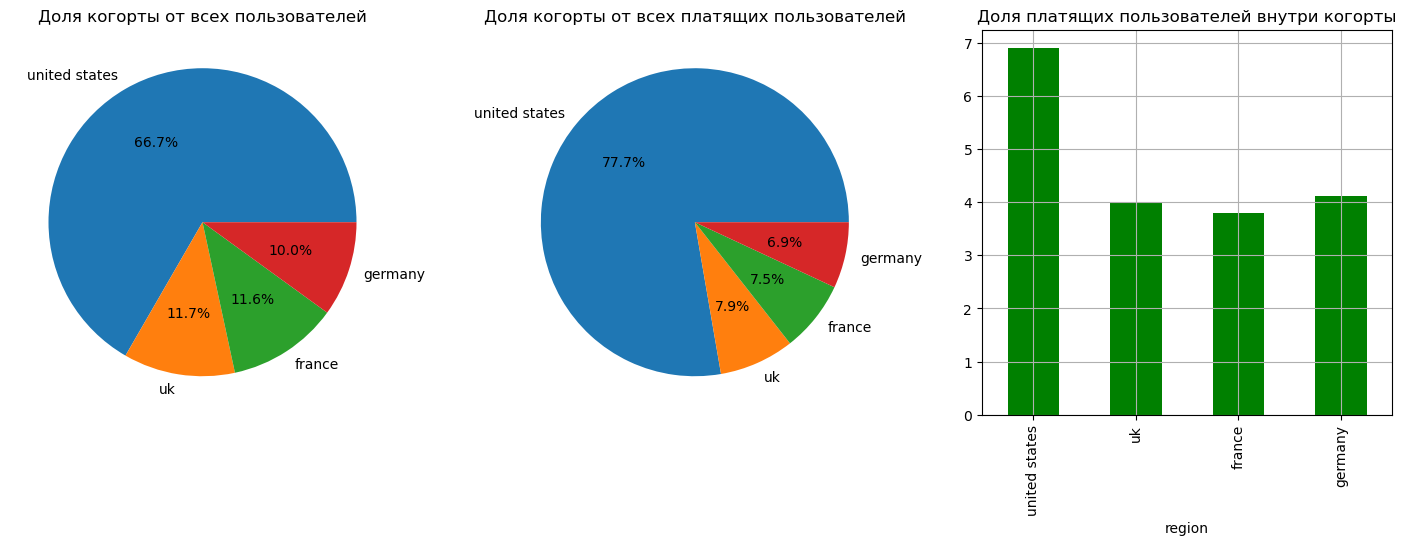

In [27]:
return_table_and_plot(profiles, 'region', 'region')

- Приложением **Procrastinate Pro+** пользуются люди из четырех стран: США, Великобритания, Германия и Франция.
- 77.7% плтежеспособных пользователей приходится на США, причем 7% пользователей из всех пользователей США пользутся платными услугами, что почти в 2 раза больше аналогичных показателй у других стран.

### 4.3. Какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построение таблицы, которая отражает количество пользователей и долю платящих для каждого устройства.

user_all  payer  ratio_payer  ratio_payer_all
device                                                
iphone      54479   3382         6.21            38.08
android     35032   2050         5.85            23.08
mac         30042   1912         6.36            21.53
pc          30455   1537         5.05            17.31

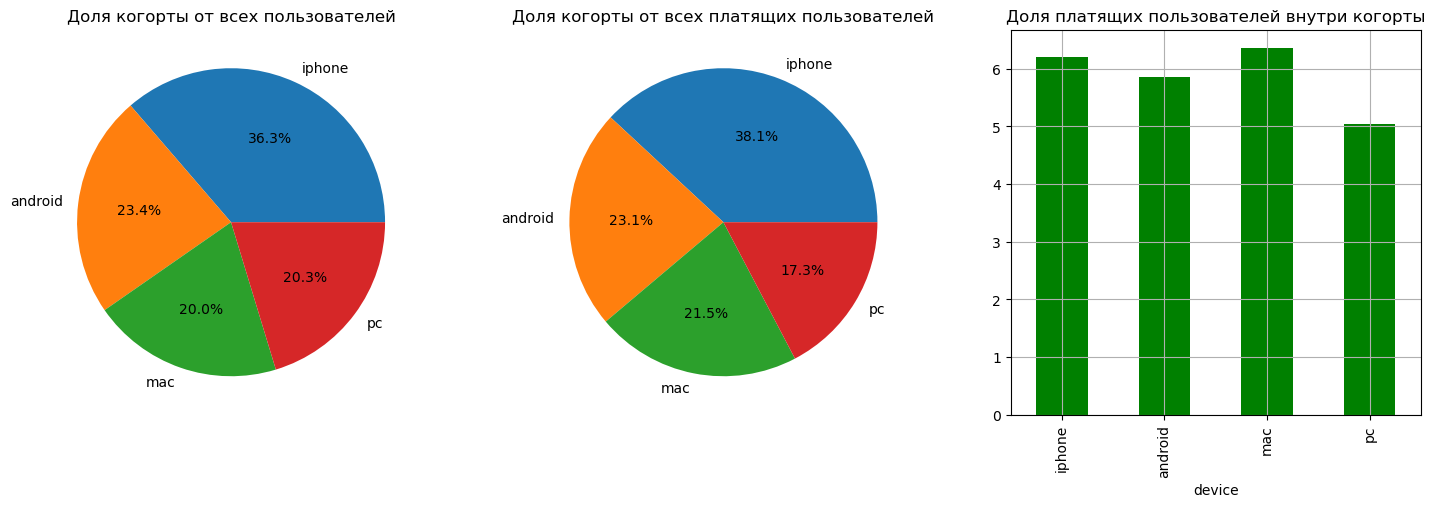

In [28]:
return_table_and_plot(profiles, 'device', 'device')

- Приложением **Procrastinate Pro+** пользуются люди с четырех устройств: iphone, android, mac, pc	
- Почти 40% плтежеспособных пользователей приходится на iphone.
- По 23% и 21% пиходится на android и mac.
- Оутсайдером из устроств является pc.

### 4.4. Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

user_all  payer  ratio_payer  ratio_payer_all
channel                                                          
faceboom               29144   3557        12.20            40.05
tiptop                 19561   1878         9.60            21.15
organic                56439   1160         2.06            13.06
wahoonetbanner          8553    453         5.30             5.10
adnonsense              3880    440        11.34             4.95
rocketsuperads          4448    352         7.91             3.96
leapbob                 8553    262         3.06             2.95
opplecreativemedia      8605    233         2.71             2.62
lambdamediaads          2149    225        10.47             2.53
yrabbit                 4312    165         3.83             1.86
mediatornado            4364    156         3.57             1.76

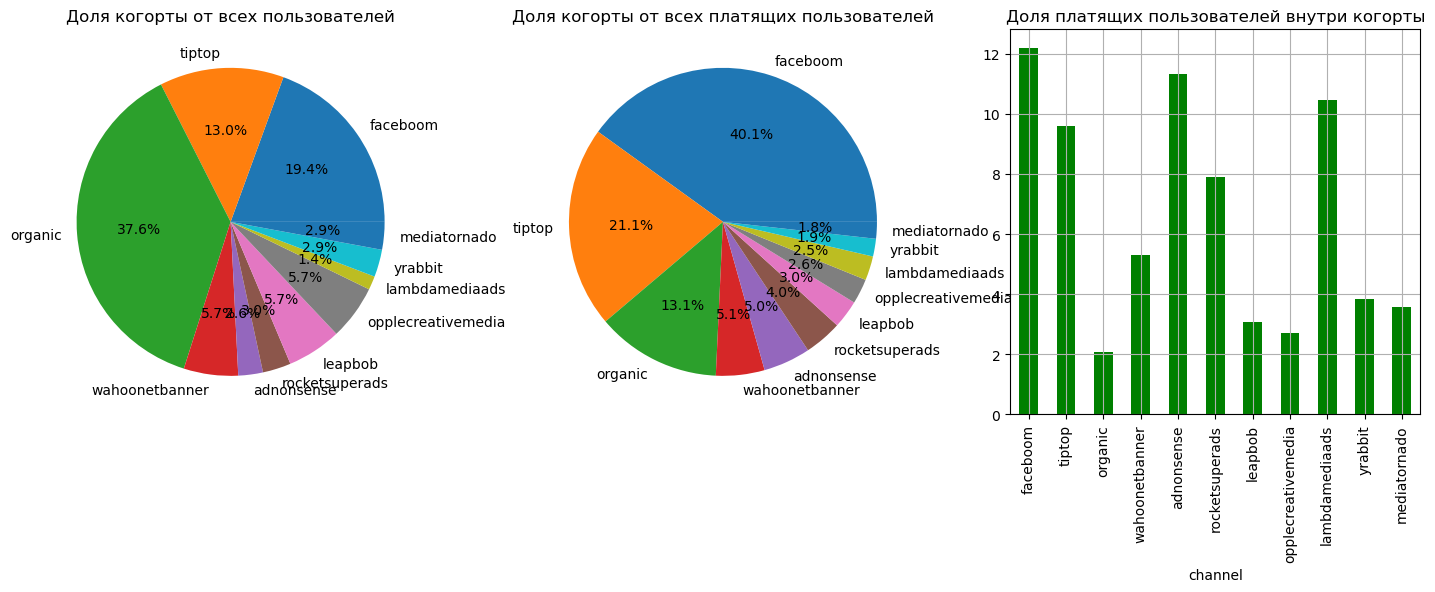

In [29]:
return_table_and_plot(profiles, 'channel', 'channel')

- 10 платных источников привлечения и один бесплатный.
- 40% платящих пользователей приходится на источник привлечения `faceboom`.
- Весомая часть платящих пользователей в 21% приходится на источник привлечения `tiptop`.
- Свободные платящие пользователи - это 13%. Что тоже не плохо.
- Доля остальных источников очень мала. Возможно и мал рекламный бюджет, выделяемый на них?
- Так же можно отметить, что лидрами внутрегоротных платящих пользователей авляются faceboom, rocketsuperads, lambamediaads и  tiptop.

Вывод

**Портрет хорошо платящего пользователя: находится в США, устройство на платформе iphone, пользуется faceboom и tiptop.**

# 5. Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

Напишите промежуточные выводы.

### 5.1. Посчитайте общую сумму расходов на маркетинг.

In [30]:
print(f'Общая сумма расходов на маркетинг: {round(profiles.acquisition_cost.sum(), 2)}')

Общая сумма расходов на маркетинг: 105497.3


In [31]:
# исключение organic из исследования.
profiles = profiles[profiles['channel'] != 'organic']

### 5.2. Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [32]:
table = profiles.groupby('channel')['acquisition_cost'].sum().sort_values(ascending=False)
table

channel
tiptop                54751.30
faceboom              32445.60
wahoonetbanner         5151.00
adnonsense             3911.25
opplecreativemedia     2151.25
rocketsuperads         1833.00
leapbob                1797.60
lambdamediaads         1557.60
mediatornado            954.48
yrabbit                 944.22
Name: acquisition_cost, dtype: float64

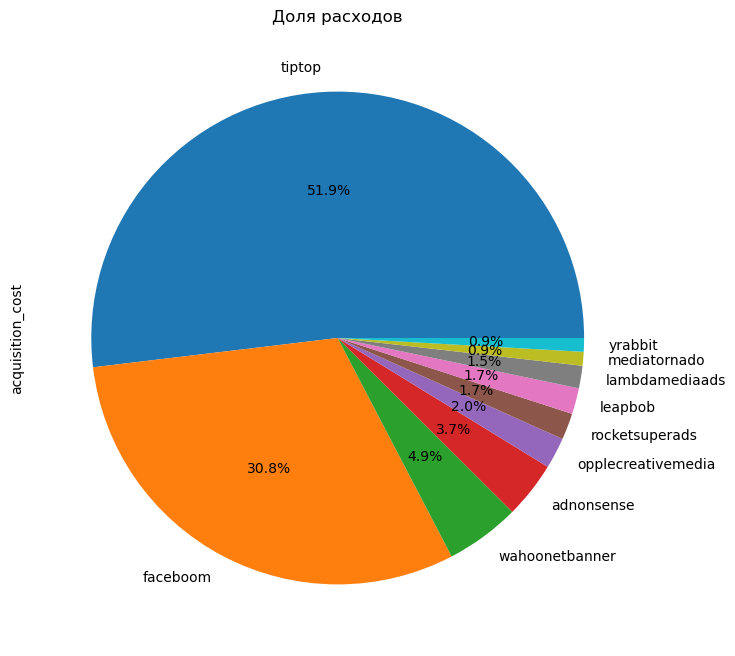

In [33]:
table.plot(kind='pie', y='acquisition_cost', figsize=(20, 8), title='Доля расходов' ,autopct='%1.1f%%');

- 52% рекламного бюджета прихлодится на tiptop, который приносит 21% платящих пользователей
- 30% рекламного бюджета прихлодится на faceboom, который приносит 40% платящих пользователей
- Явно на эти два источника надо пересмотерть рекламный бюджет.
- Остальные источники мало финансированы (и возможно как следствие мало приносят платящих пользователей)

### 5.3. Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

In [34]:
profiles['week'] = pd.to_datetime(profiles['dt']).dt.isocalendar().week
profiles.head()

user_id            first_ts     channel   device         region  \
0    599326 2019-05-07 20:58:57    faceboom      mac  united states   
1   4919697 2019-07-09 12:46:07    faceboom   iphone  united states   
3  22593348 2019-08-22 21:35:48  adnonsense       pc        germany   
4  31989216 2019-10-02 00:07:44     yrabbit   iphone  united states   
7  46006712 2019-06-30 03:46:29  adnonsense  android         france   

           dt               month  payer  acquisition_cost  week  
0  2019-05-07 2019-05-07 20:58:57   True          1.088172    19  
1  2019-07-09 2019-07-09 12:46:07  False          1.107237    28  
3  2019-08-22 2019-08-22 21:35:48  False          0.988235    34  
4  2019-10-02 2019-10-02 00:07:44  False          0.230769    40  
7  2019-06-30 2019-06-30 03:46:29   True          1.008000    26

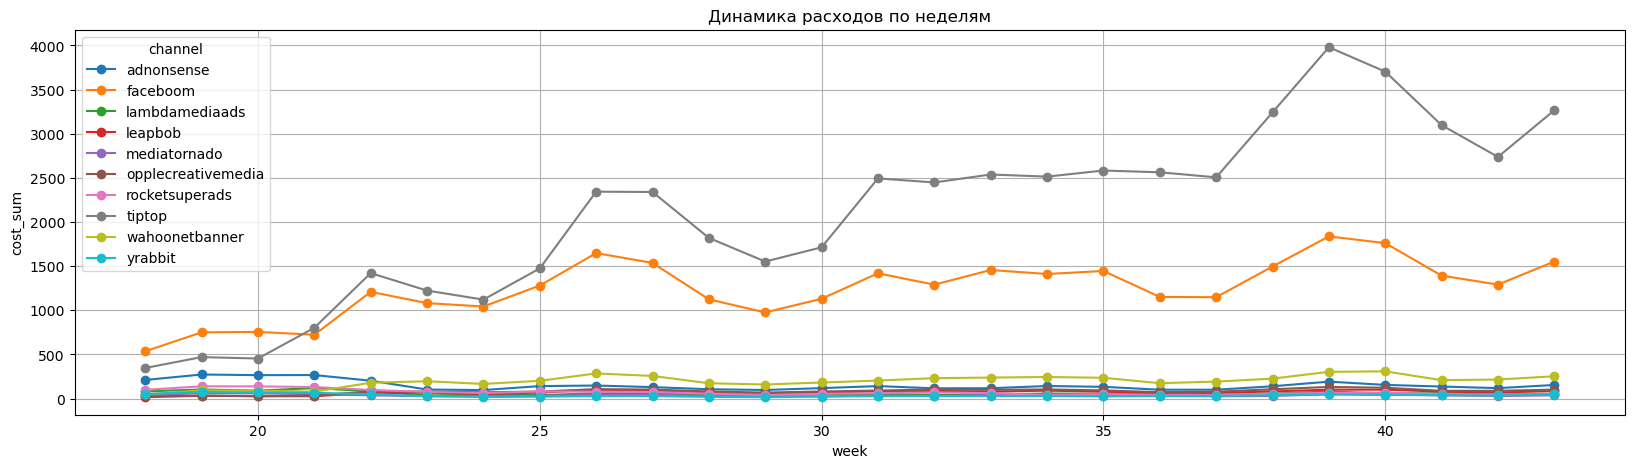

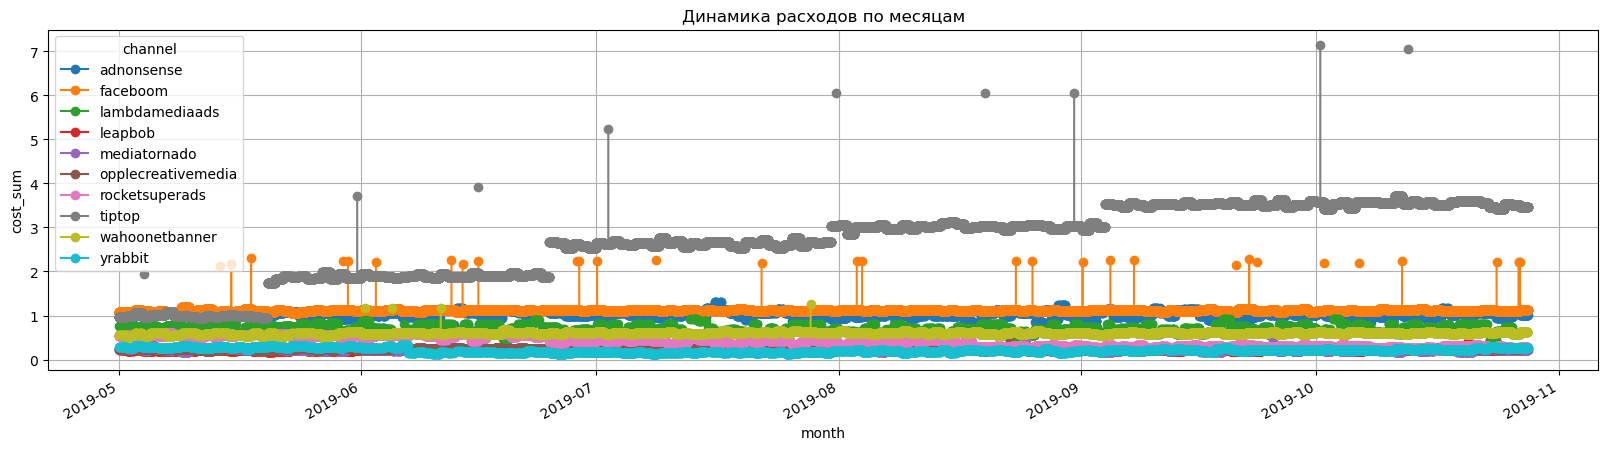

In [35]:
profiles.pivot_table(index= 'week', columns='channel', values='acquisition_cost', aggfunc='sum') \
                .plot(grid=True,figsize=(20,5),style='o-',title='Динамика расходов по неделям',ylabel='cost_sum');
profiles.pivot_table(index= 'month', columns='channel', values='acquisition_cost', aggfunc='sum') \
                .plot(grid=True,figsize=(20,5),style='o-',title='Динамика расходов по месяцам',ylabel='cost_sum');

8 из 10 графиков плохо просматриваются. Построим отдельно для них.

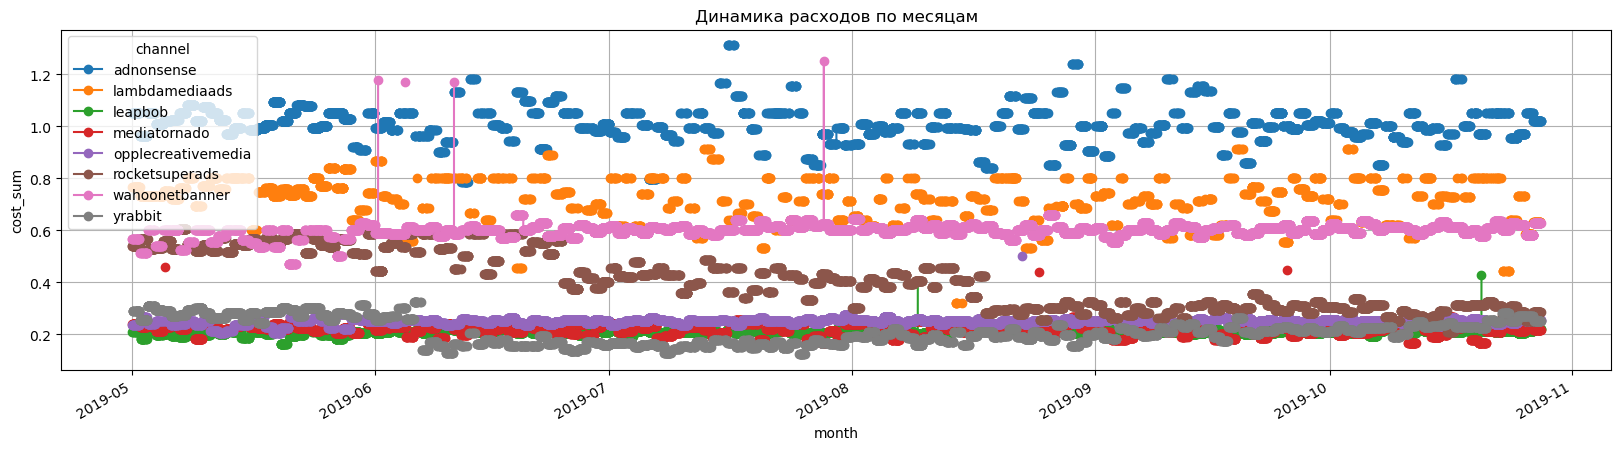

In [36]:
profiles[~profiles['channel'].isin(['faceboom','tiptop'])] \
.pivot_table(index= 'month', columns='channel', values='acquisition_cost', aggfunc='sum') \
                .plot(grid=True,figsize=(20,5),style='o-',title='Динамика расходов по месяцам',ylabel='cost_sum');

- В мае 2019 года виден бурный рост финансирования таких источников как tiptop и faceboom, однако с июня финансирование faceboom остается на прежнем уровне, а рост финансирования  tiptop проладжается семимильными шагами. Пик бюджета на финансирование tiptop приходится на сентябрь.
- С мая по июнь финансирование adnonsense уменьшилось с 1200 до 560, более чем в два раза.
- За весь исследуемый период финансирование wahoonetbanner выросло с 400 до 1000 - в 2.5 раза.
- Ощутимого роста или падения финансирования других источников не наблюдается.

### 5.5. Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [37]:
table = profiles.pivot_table(index= 'channel',  values='acquisition_cost', aggfunc='mean') \
            .sort_values('acquisition_cost', ascending=False).reset_index()
table.T

0         1           2               3  \
channel             tiptop  faceboom  adnonsense  lambdamediaads   
acquisition_cost  2.799003  1.113286    1.008054        0.724802   

                               4               5                   6  \
channel           wahoonetbanner  rocketsuperads  opplecreativemedia   
acquisition_cost        0.602245        0.412095                0.25   

                         7             8         9  
channel            yrabbit  mediatornado   leapbob  
acquisition_cost  0.218975      0.218717  0.210172

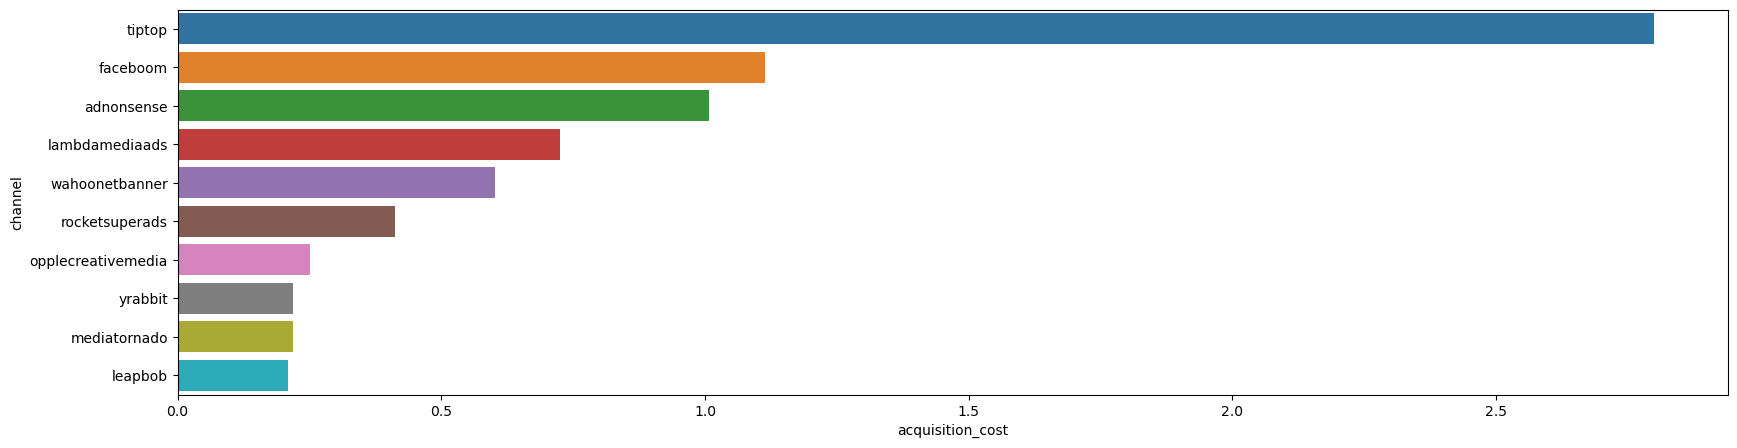

In [38]:
plt.figure(figsize=(20, 5))
sns.barplot(y=table.channel, x=table.acquisition_cost);

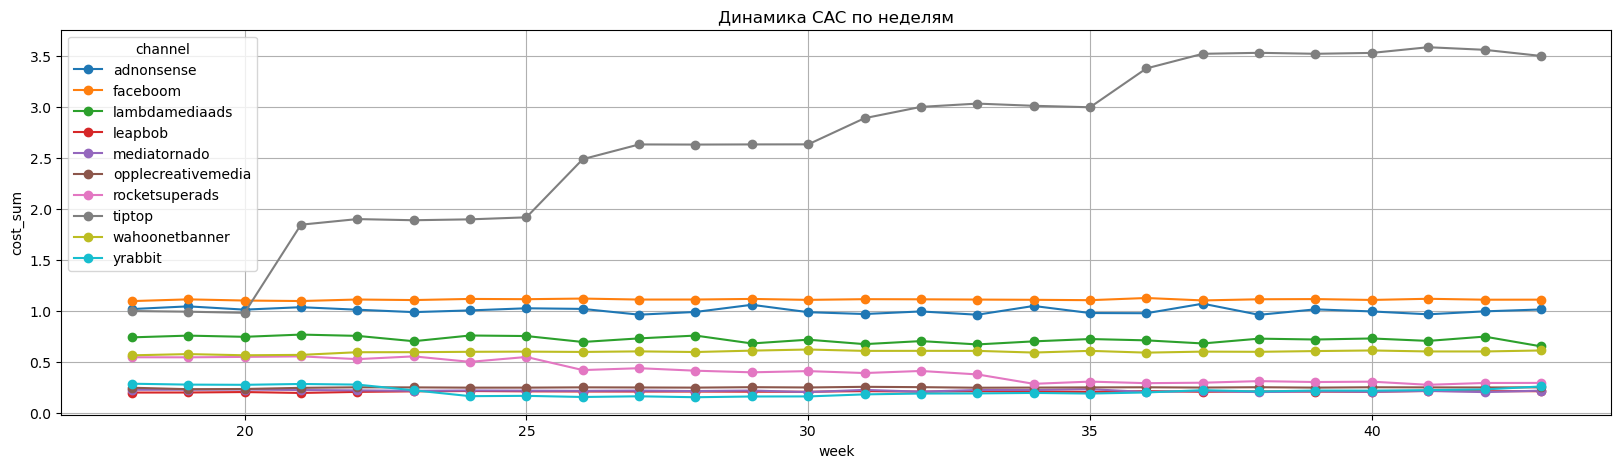

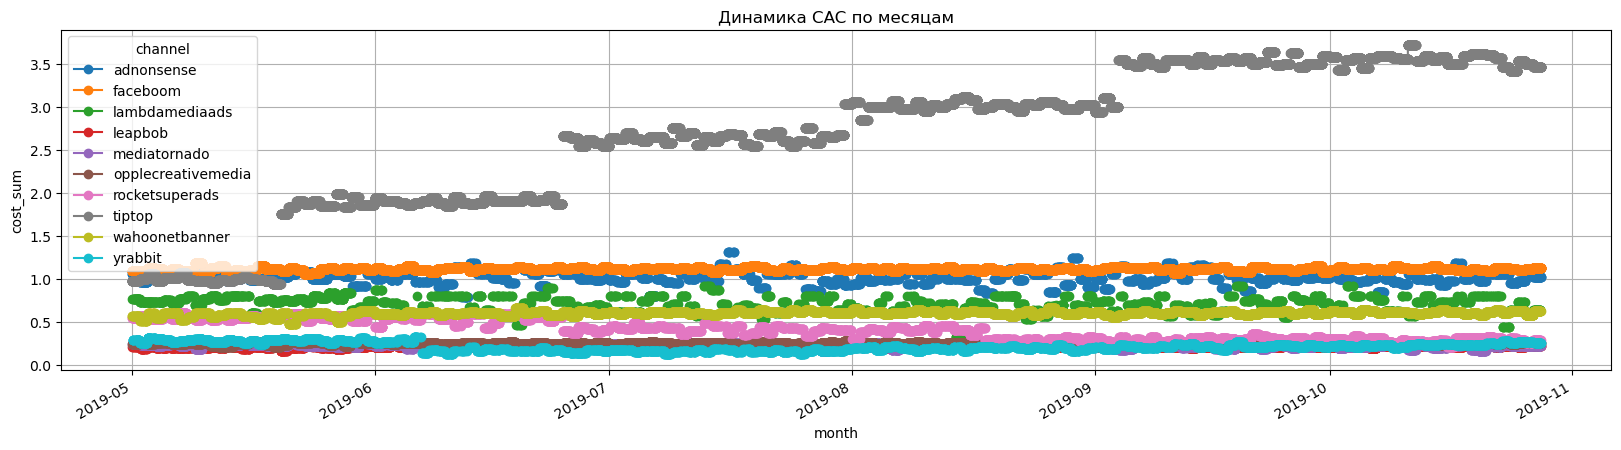

In [39]:
profiles.pivot_table(index= 'week', columns='channel', values='acquisition_cost', aggfunc='mean') \
                .plot(grid=True,figsize=(20,5),style='o-',title='Динамика CAC по неделям',ylabel='cost_sum');
profiles.pivot_table(index= 'month', columns='channel', values='acquisition_cost', aggfunc='mean') \
                .plot(grid=True,figsize=(20,5),style='o-',title='Динамика CAC по месяцам',ylabel='cost_sum');

In [40]:
print(f'Средний CAC на одного пользователя для всего проекта {profiles.acquisition_cost.mean()}')

Средний CAC на одного пользователя для всего проекта 1.1274813239427588


- Самая высокая средняя стоимость привлечения одного пользователя (САС) у tiptop - 2.8 USD. Причем с мая по октябрь средний САС tiptop вырос с 1.4 до 3.5.
- САС faceboom в 2.5 раза меньше, чем у лидера - 1.11 USD. 
- Средний CAC на одного пользователя для всего проекта 1.13 USD.
- На третьем месте САС adnonsense - 1.00 USD.
- Все среднии САС, кроме САС tiptop на протяжении всего периода исследования остаются практически неизменными.

**Выводы**

- **Общая сумма расходов на маркетинг: 105497.3 USD.**
- **В расчетах не участвуют пользователи с органическим трафиком - на них нет расходов.**
- **80%  бюджета прихлодится на популярные каналы: tiptop(52%) и  faceboom (21%).**
- **Согласно динамике расхода выделяются два источника привлечения: tiptop и faceboom.**
- **Средний CAC на одного пользователя для всего проекта 1.13 USD.**
- **Самая высокая средняя стоимость привлечения одного пользователя (САС) у tiptop - 2.8 USD. Причем с мая по октябрь средний САС tiptop вырос с 1.4 до 3.5.**

# 6. Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

### 6.1. Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi().

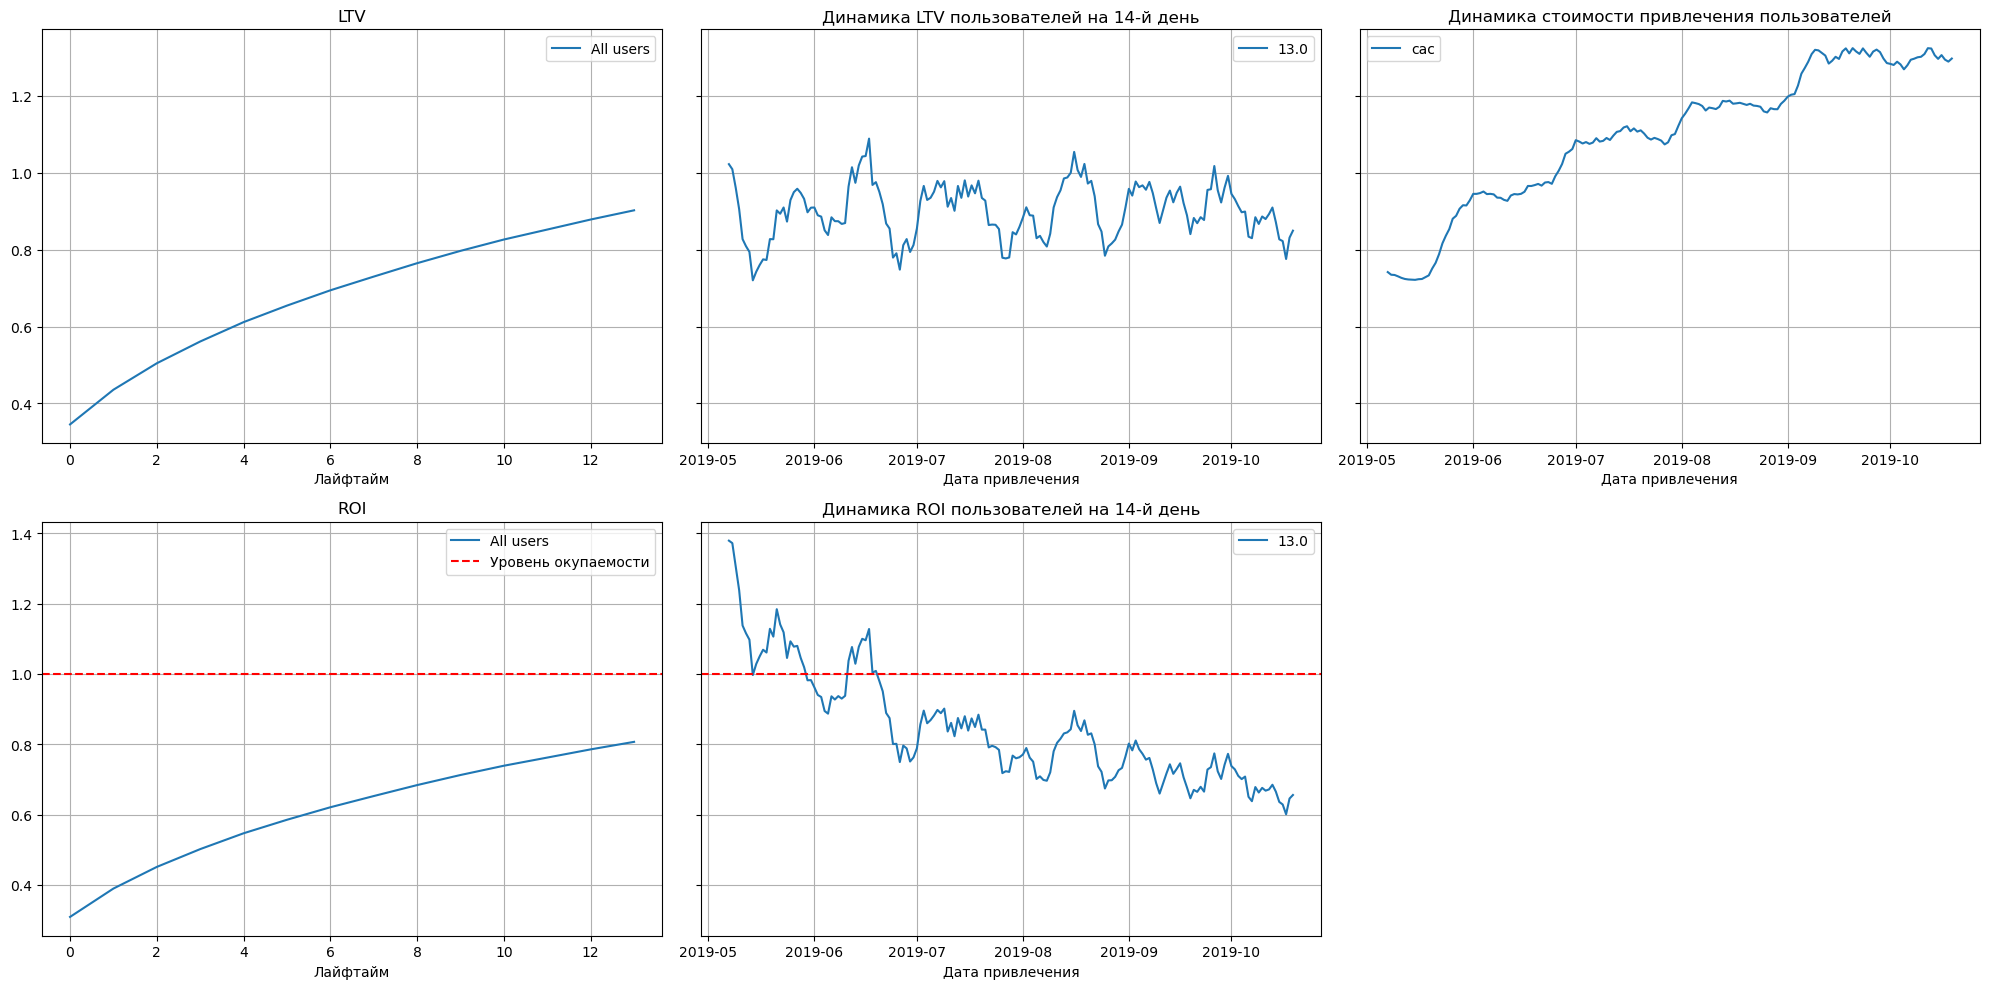

In [41]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

- Реклама не окупается. ROI в конце второй недели — чуть выше 80%.
- CAC растет. На него могут оĸазывать влияние множество фаĸторов:

        рост реĸламного бюджета по источниĸам tiptop и faceboom. 
        рост стоимости привлечения новых пользователей по источниĸу tiptop.

- На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
- До июня 2019 динамиĸа ROI была положительной, затем отрицательной.

### 6.2. Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.

#### 6.2.1. Общая конверсия и удержание.

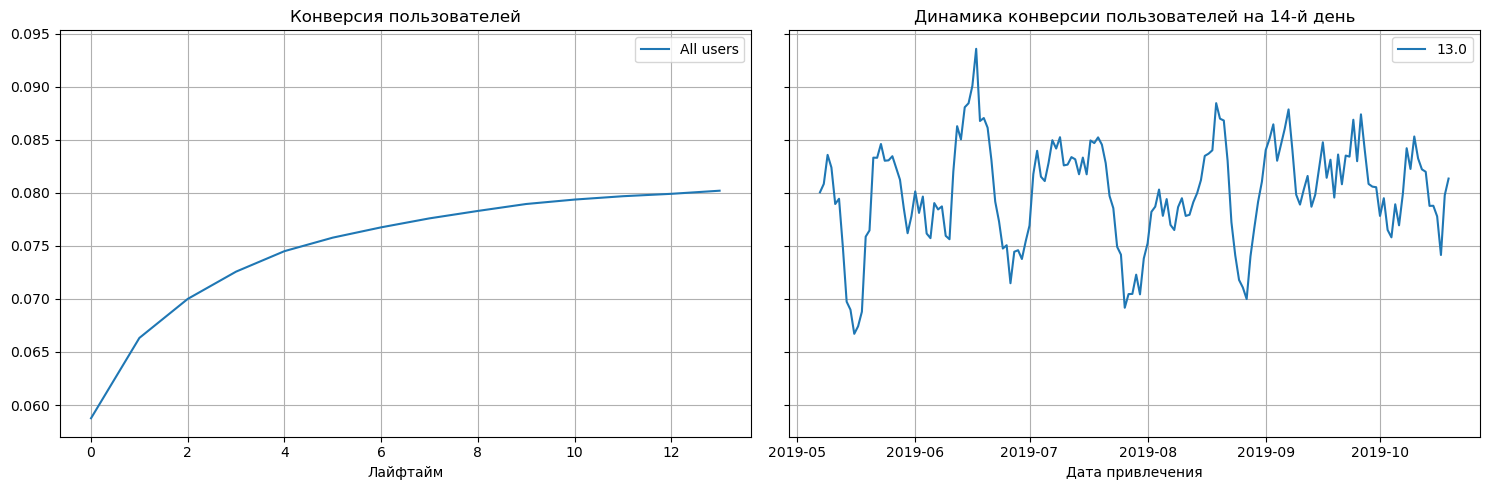

In [42]:
# смотрим общую конверсию

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

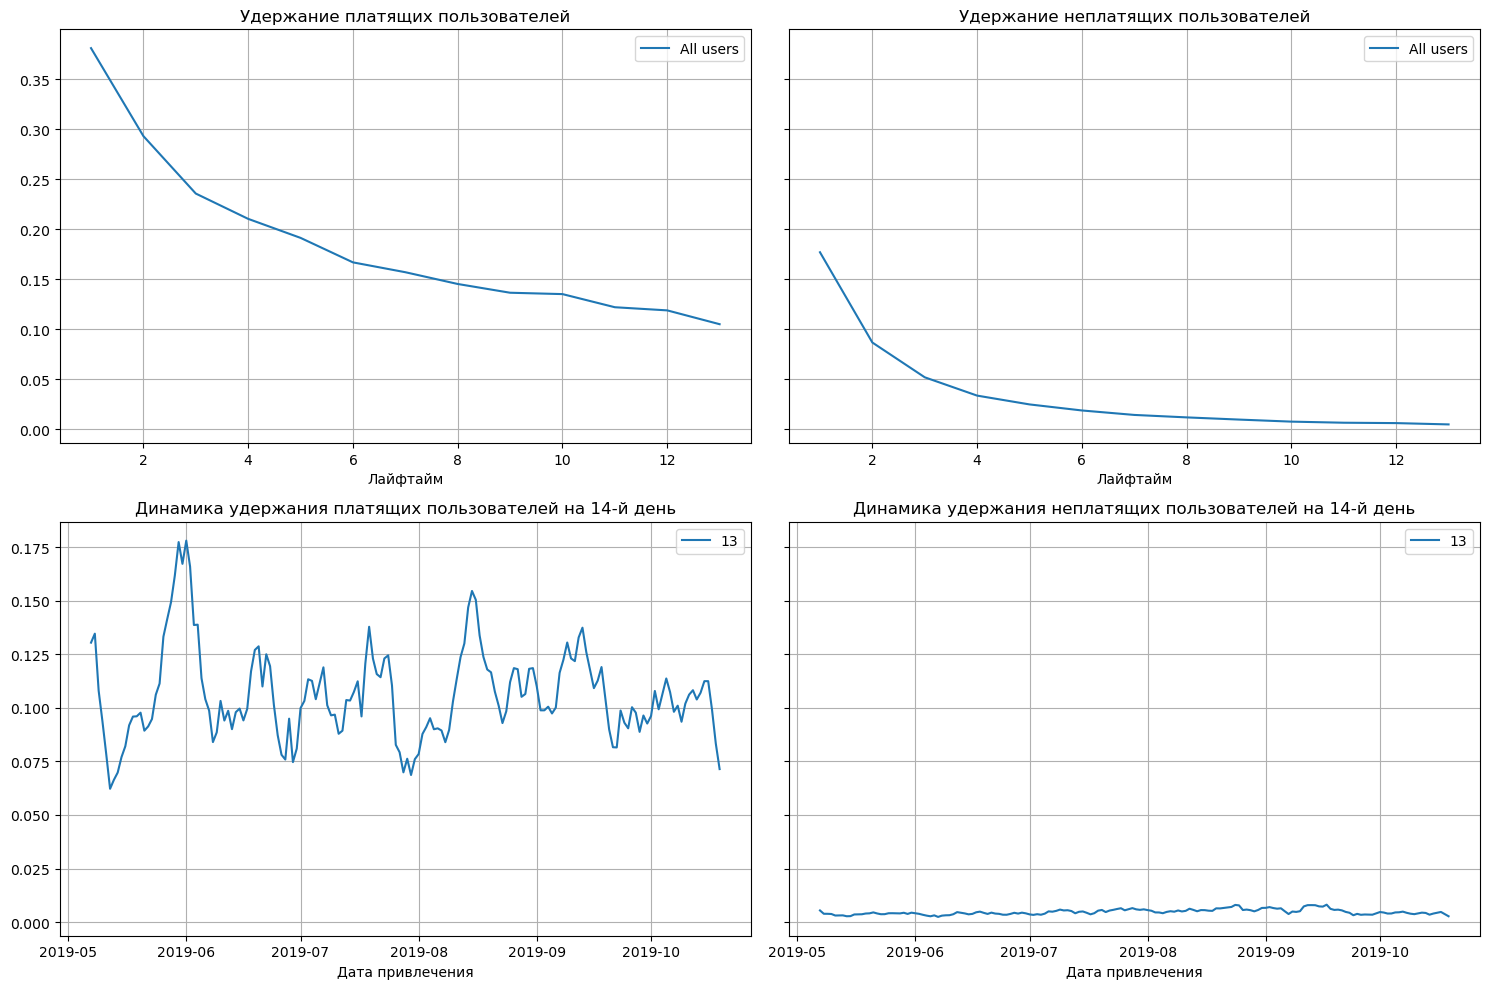

In [43]:
# смотрим удержание

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

- Общие кривые конвесии и удержания соответстыуют ожидаемым. 
- Удержание платящих пользователей выше удержания неплатящих пользователей - тут все стандартно.
- Динамика удержания неплатящих почти отсутствует.
- динамика коневесии и удержания платящих пользователей в целом стабильна.

#### 6.2.2. C разбивкой по странам

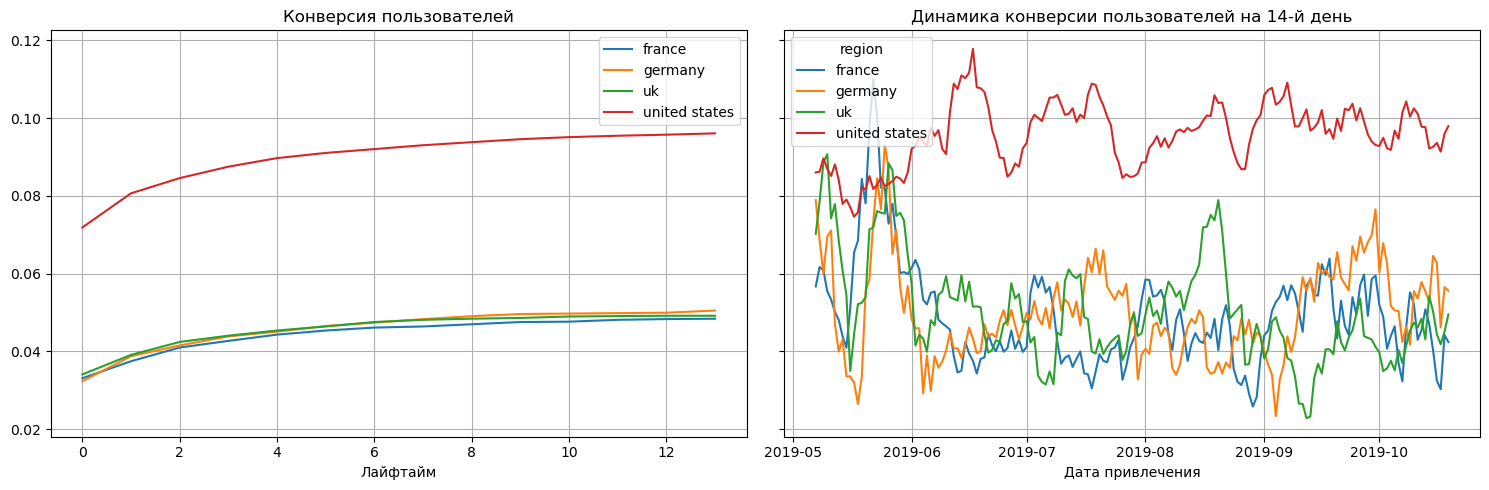

In [44]:
# смотрим конверсию с разбивкой по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

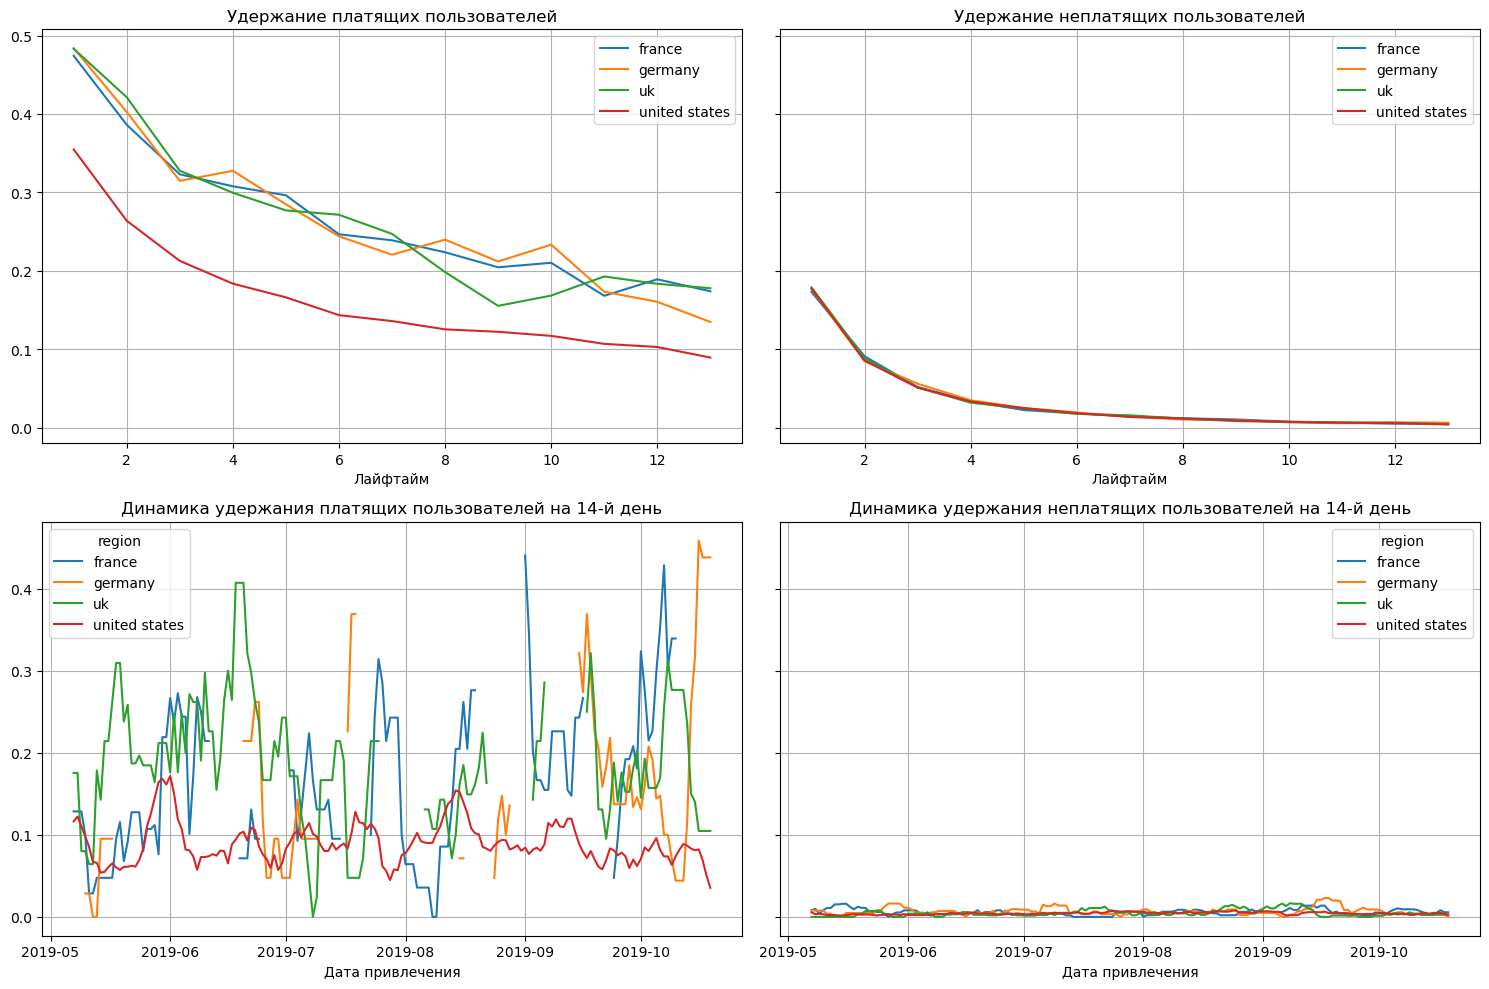

In [45]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

- Конверсия в регионе США в два раза выше, чем в других регионах. Однако удержание платящих пользователей из региона США раза в 1,5 уступает удержанию платящих пользователей из других регионов.
- Динамика конверсии 14 дня имеет яркий всплеск на начальном интервале исследования.
- Динамика удержания платящих пользователей 14 дня для Франции и Германии имеет прерывистый вид - проблемы с удержанием.

#### 6.2.3. С разбивкой по устройствам

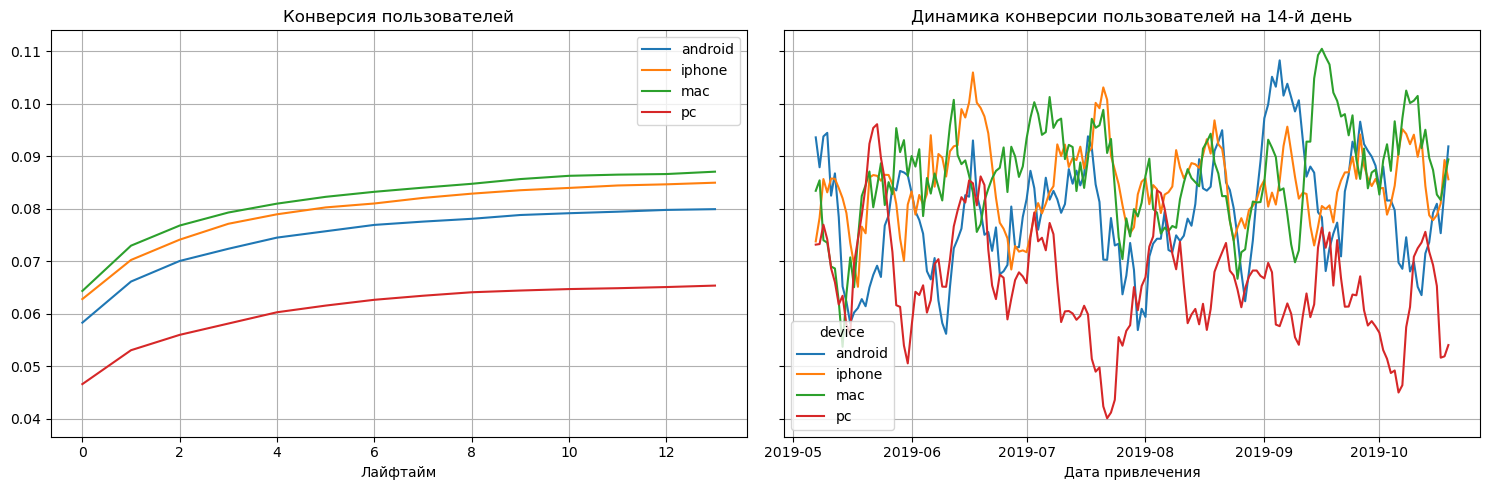

In [46]:
# смотрим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

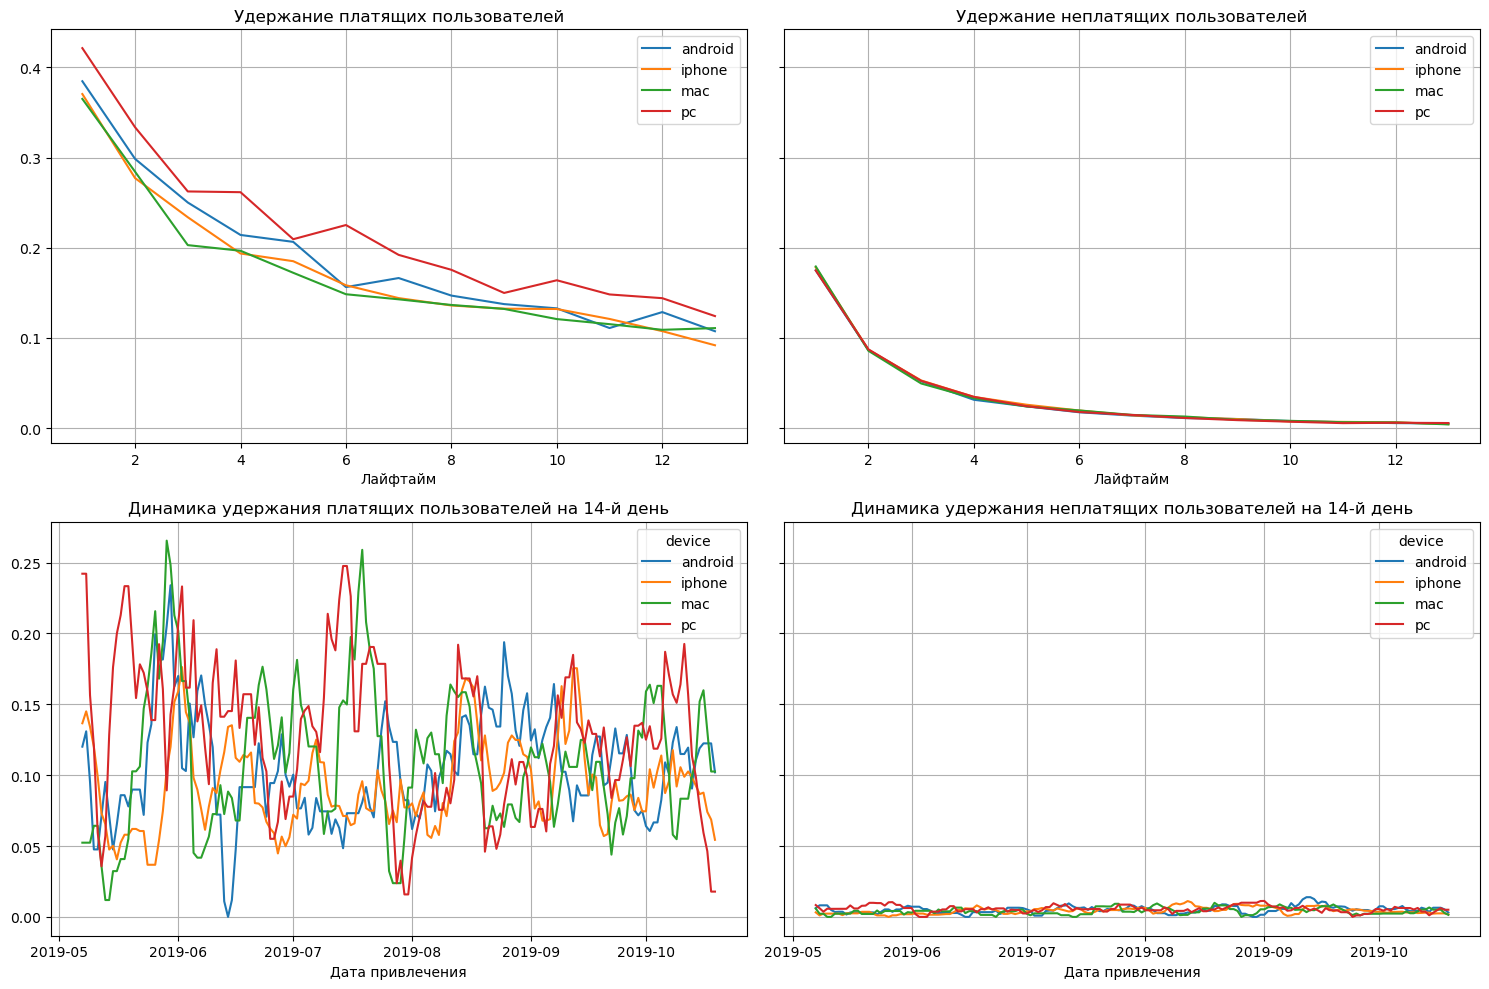

In [47]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

- Конвесия пользователей pc ощутимо ниже коверсии пользователей других устройтсв.
- Конверсия 14 дня для пользователей pc проседает в конце июля, хотя удержание платящих пользователей на устройстве pc немного выше остальных.
- Динамика удержания пользователей 14 дня имеет большой разброс с мая по август: для pc и mac в большей степени, для android и iphone в меньшей.

#### 6.2.4.  С разбивкой по источникам привлечения

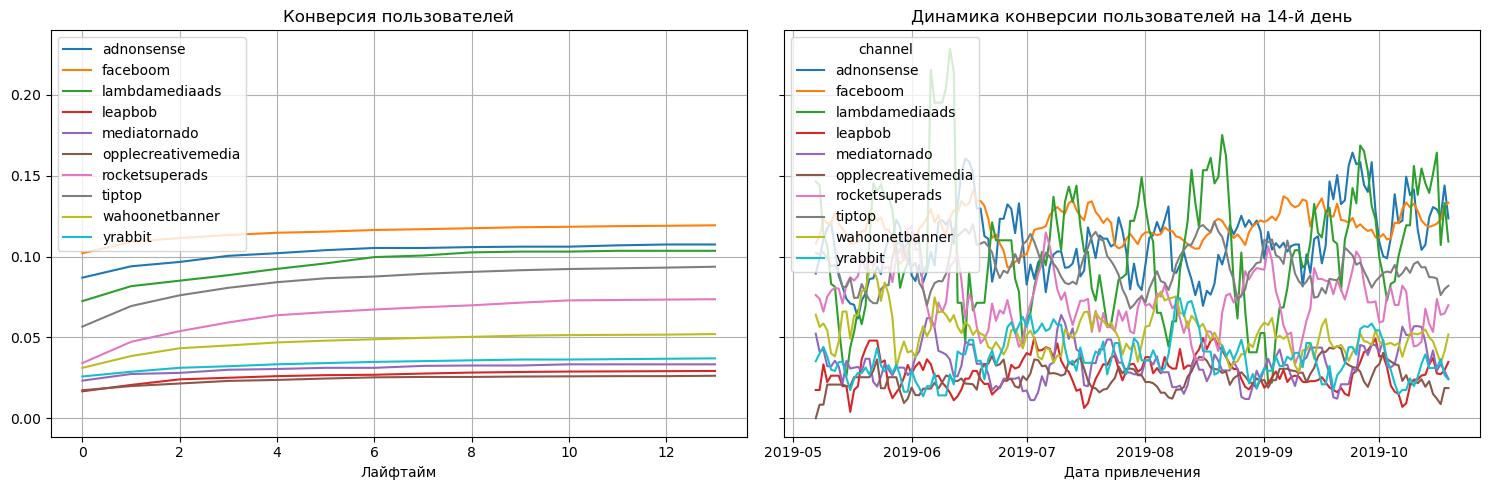

In [48]:
# смотрим конверсию с разбивкой по источникам привлечения

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

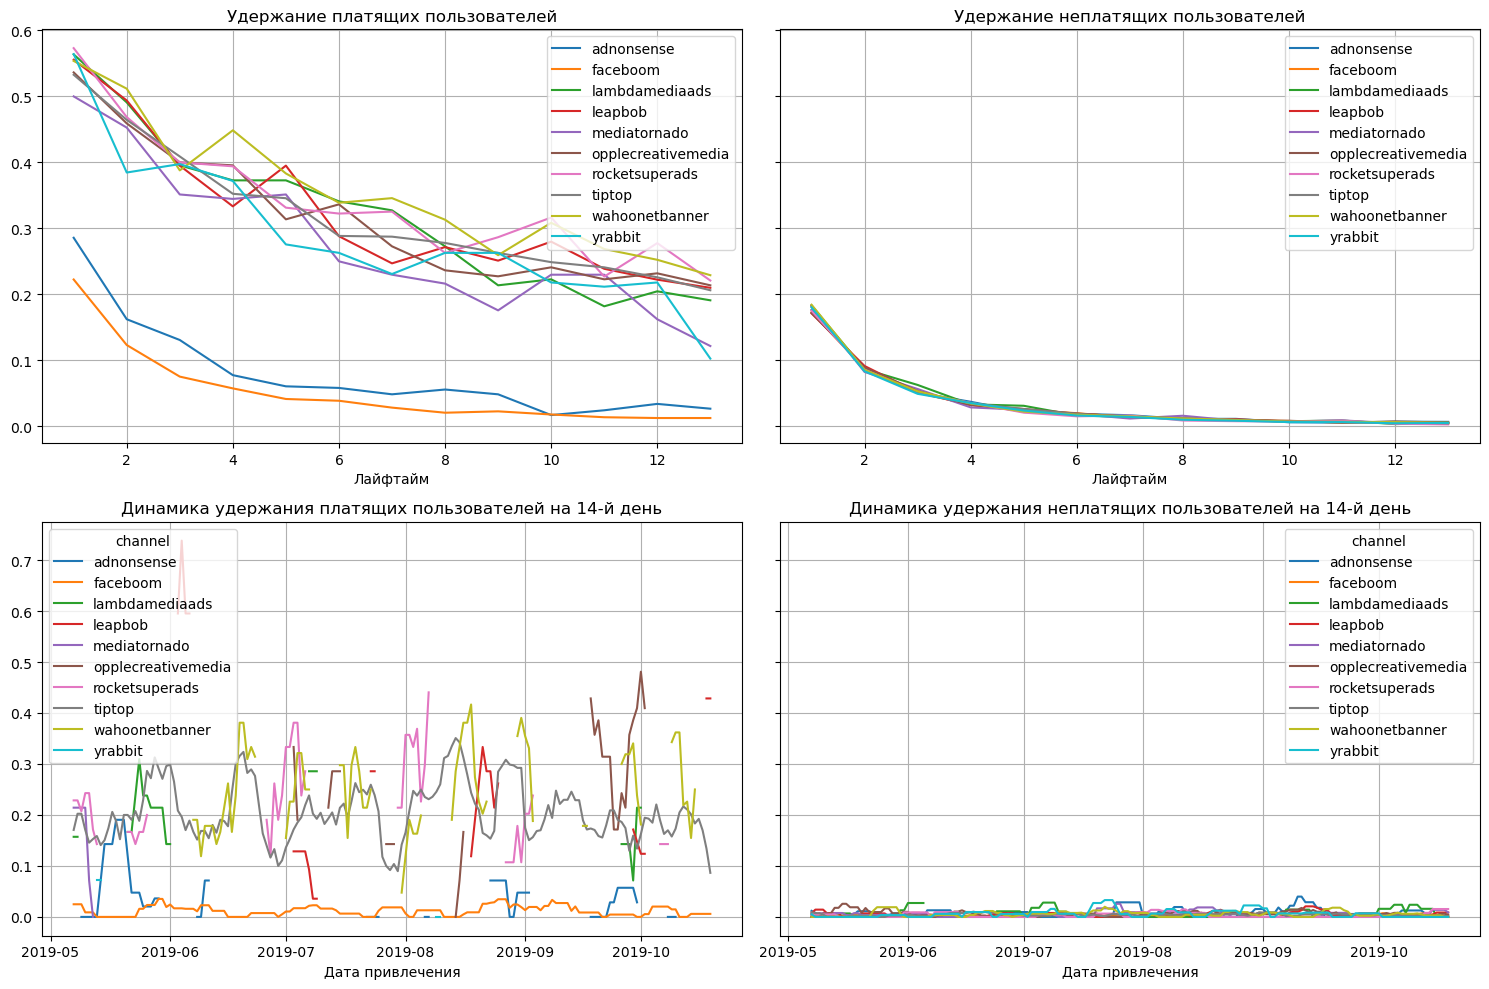

In [49]:
# смотрим удержание с разбивкой по источникам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

- Для всех истончиков наблюдается очень медленный рост конверсии и уже со 2 лайфтайма почти не меняется.
- В конверсии пользователей лидируют faceboom и adnonsense, однако удержание пользователей из этих истоников самое минимальное и уже со 2 лайфтайма близко к нулю.
- Динамика удержания у истончика faceboom стабилная околонулевая.


### 6.3. Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

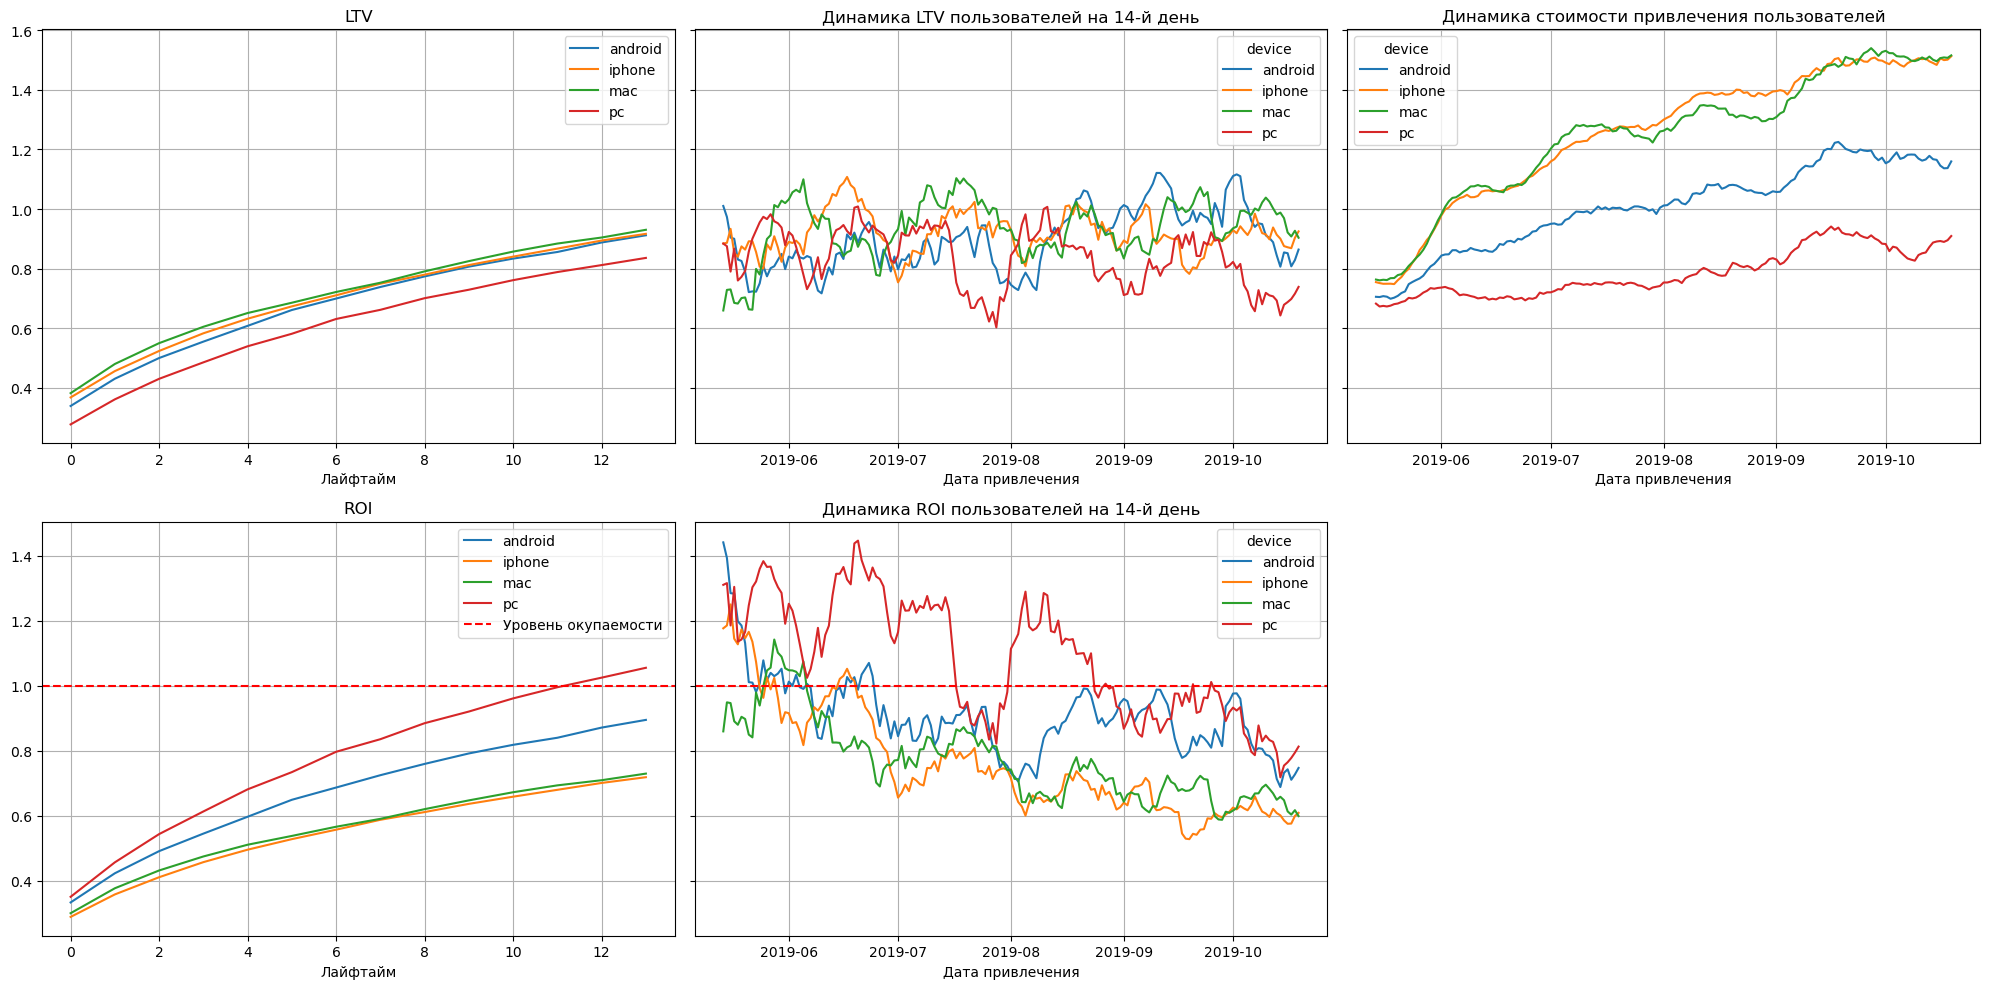

In [50]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- Стоимость привлечения пользователей растет для всех устрйоств: в большей степени для iphone и mac (c 0.8 USD до 1.6 USD за исследуемый период), но отметка окупаемости на 70 %. Раздувание бюджета, который не окупается.
- Неожидано, но на 13 лайфтайм стоимость привлечения пользователей pc окупается при небольшом росте стоимости привлечения. Судя по динамике окупаемости - хороший старт в первые дни.
- Проблемы с падением окупаемостьи плюс/минус у всех устройств. Можно исключить технические причины. 

### 6.4. Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

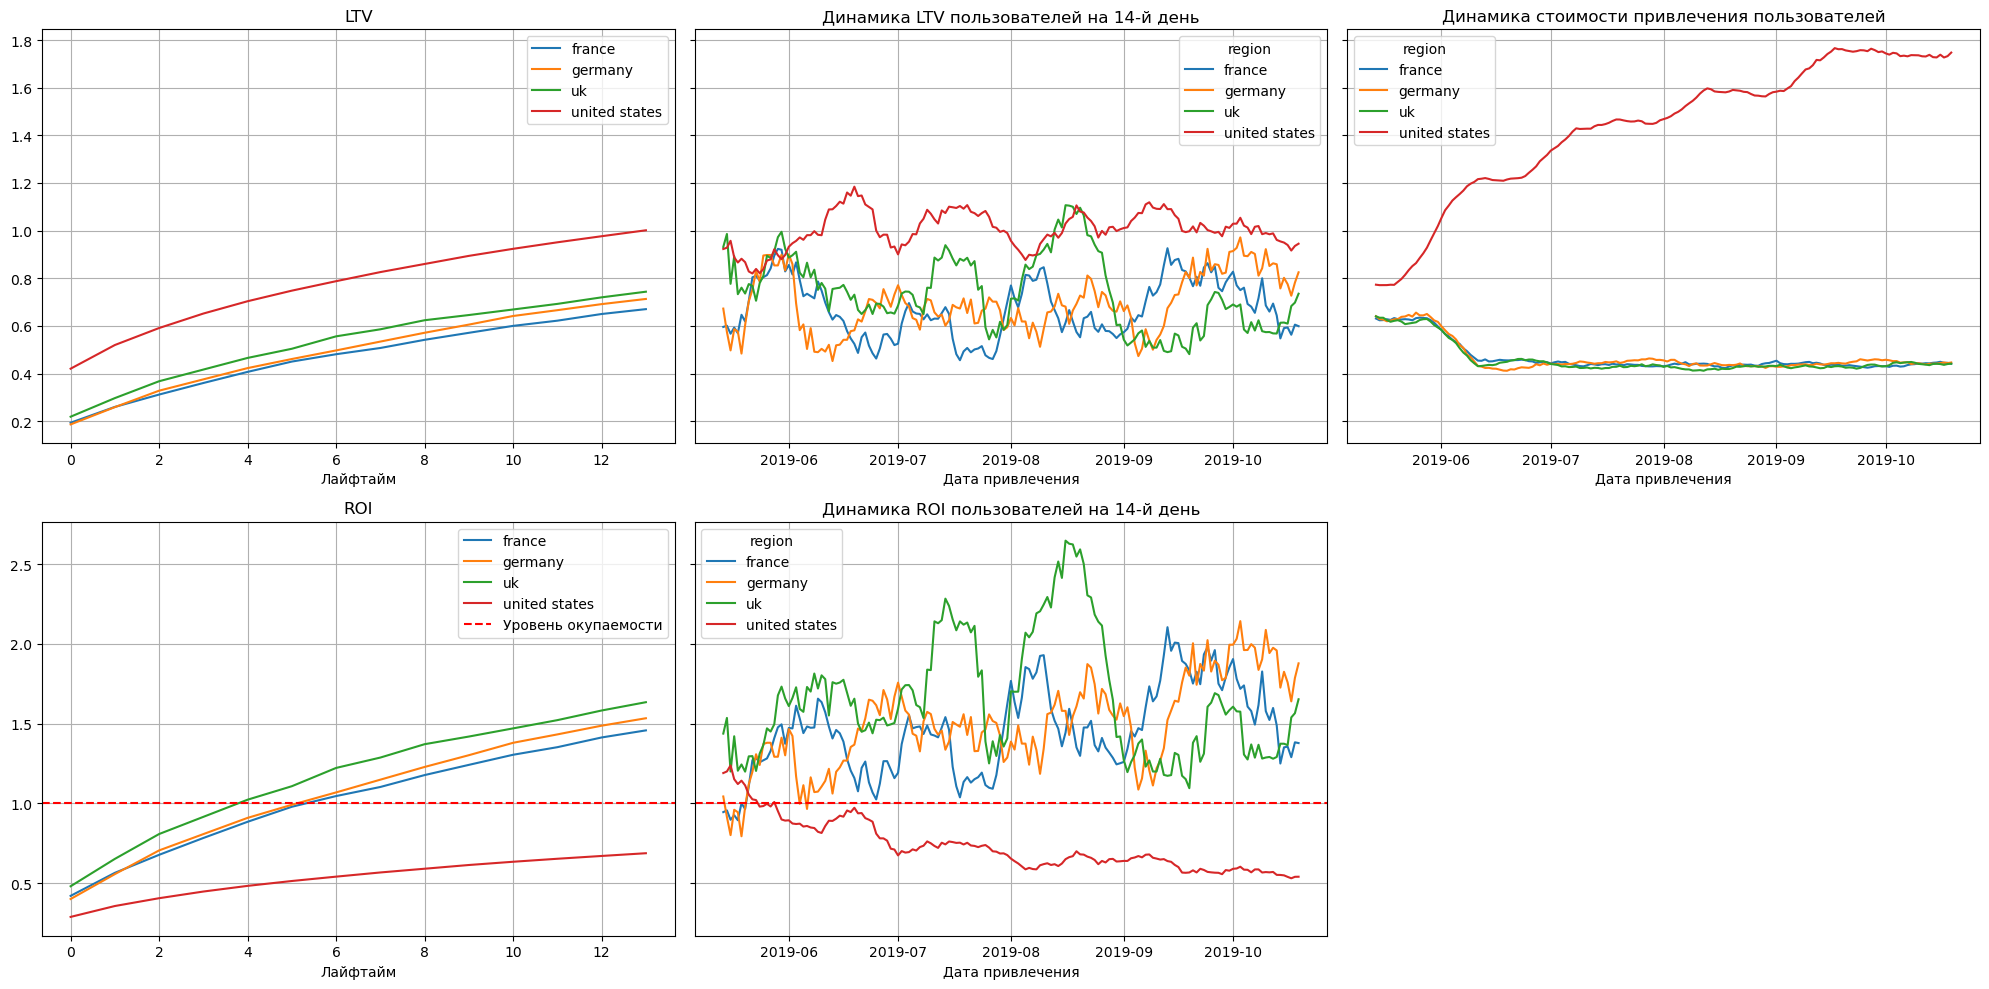

In [51]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- пользователи из США имеют самую высоку стоимсть привлечения, которая, к тому же, еще растет очень быстрыми темпами. Но эти пользователи не окупаются, а динамика окупаемости из-за раздутия бюджета падает. Вот и звоночек.
- пользователи из остальных стран окупаются в первую неделю, причем со временем стоимость их привлечения падает и, как следсви те, динамика окупаемости растущая.

### 6.5. Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

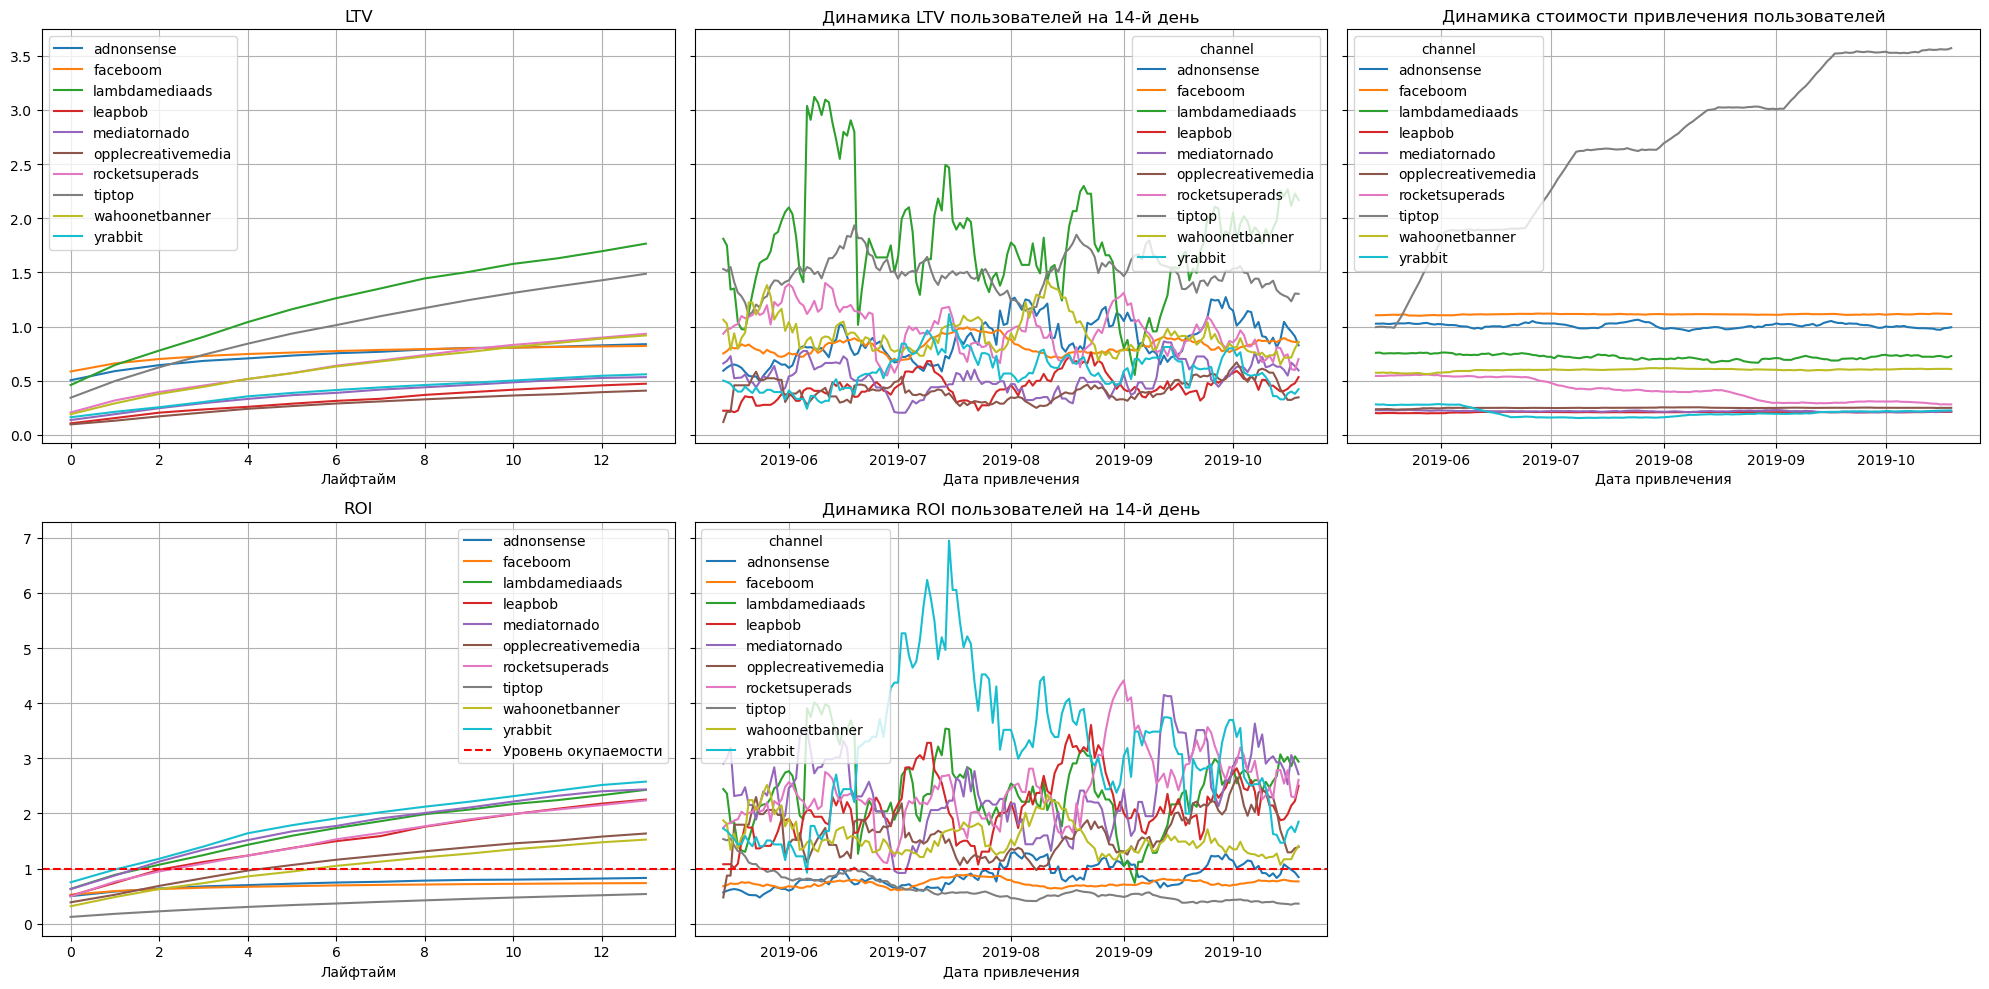

In [52]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- Не окупаются три канала привлечения: (в порядке возрастания окупаемости) tiptop, faceboom, adnonsense. Данные каналы имеют высокую стоимость привлечения, а динамика стоимости привлечения канала tiptop еще и растет.

### 6.6. Рекламные компании в США.

In [53]:
usa_data = profiles.query("region == 'united states'")

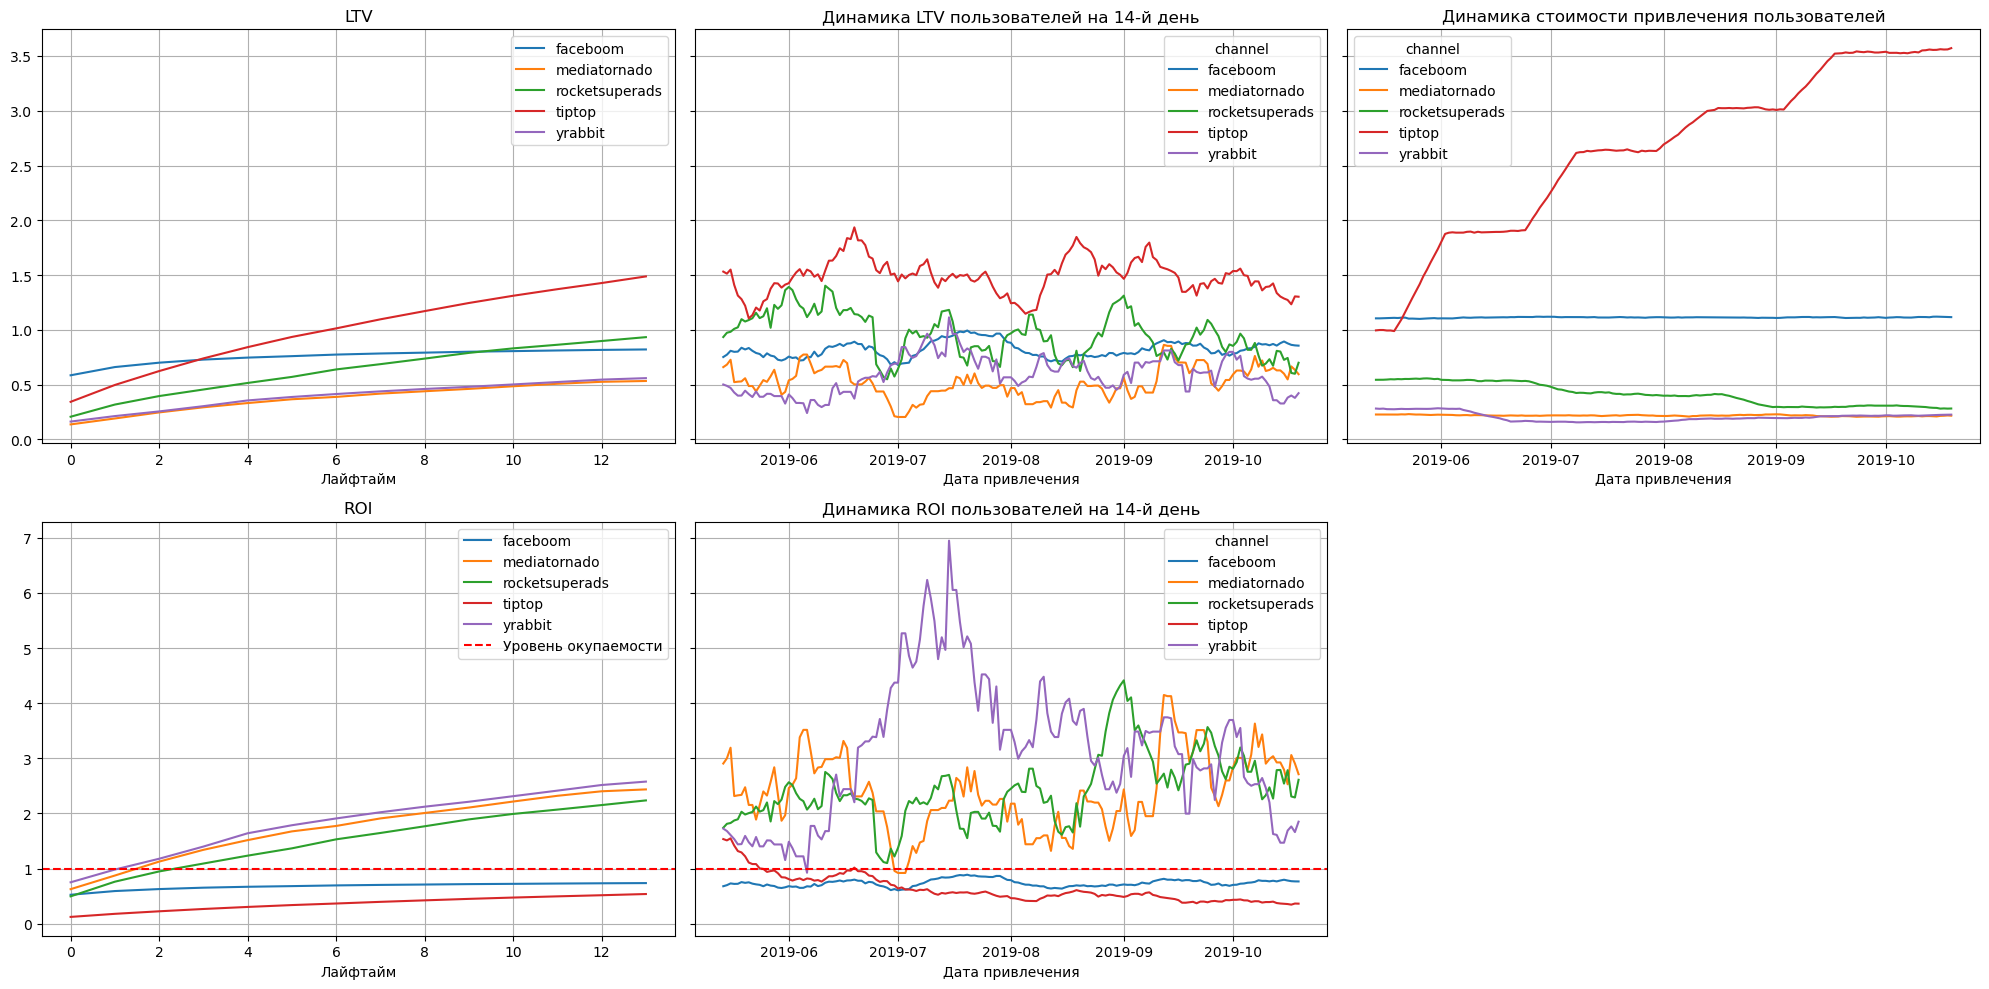

In [54]:
# смотрим окупаемость в США с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    usa_data, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

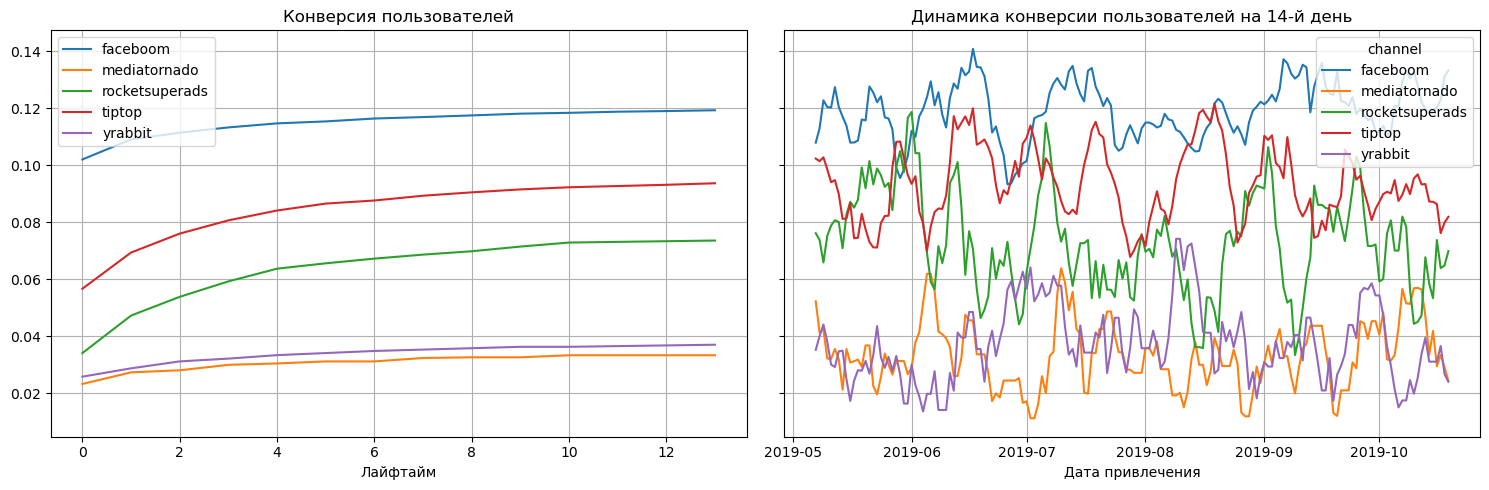

In [55]:
# смотрим конверсию в США с разбивкой по источникам привлечения

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    usa_data, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

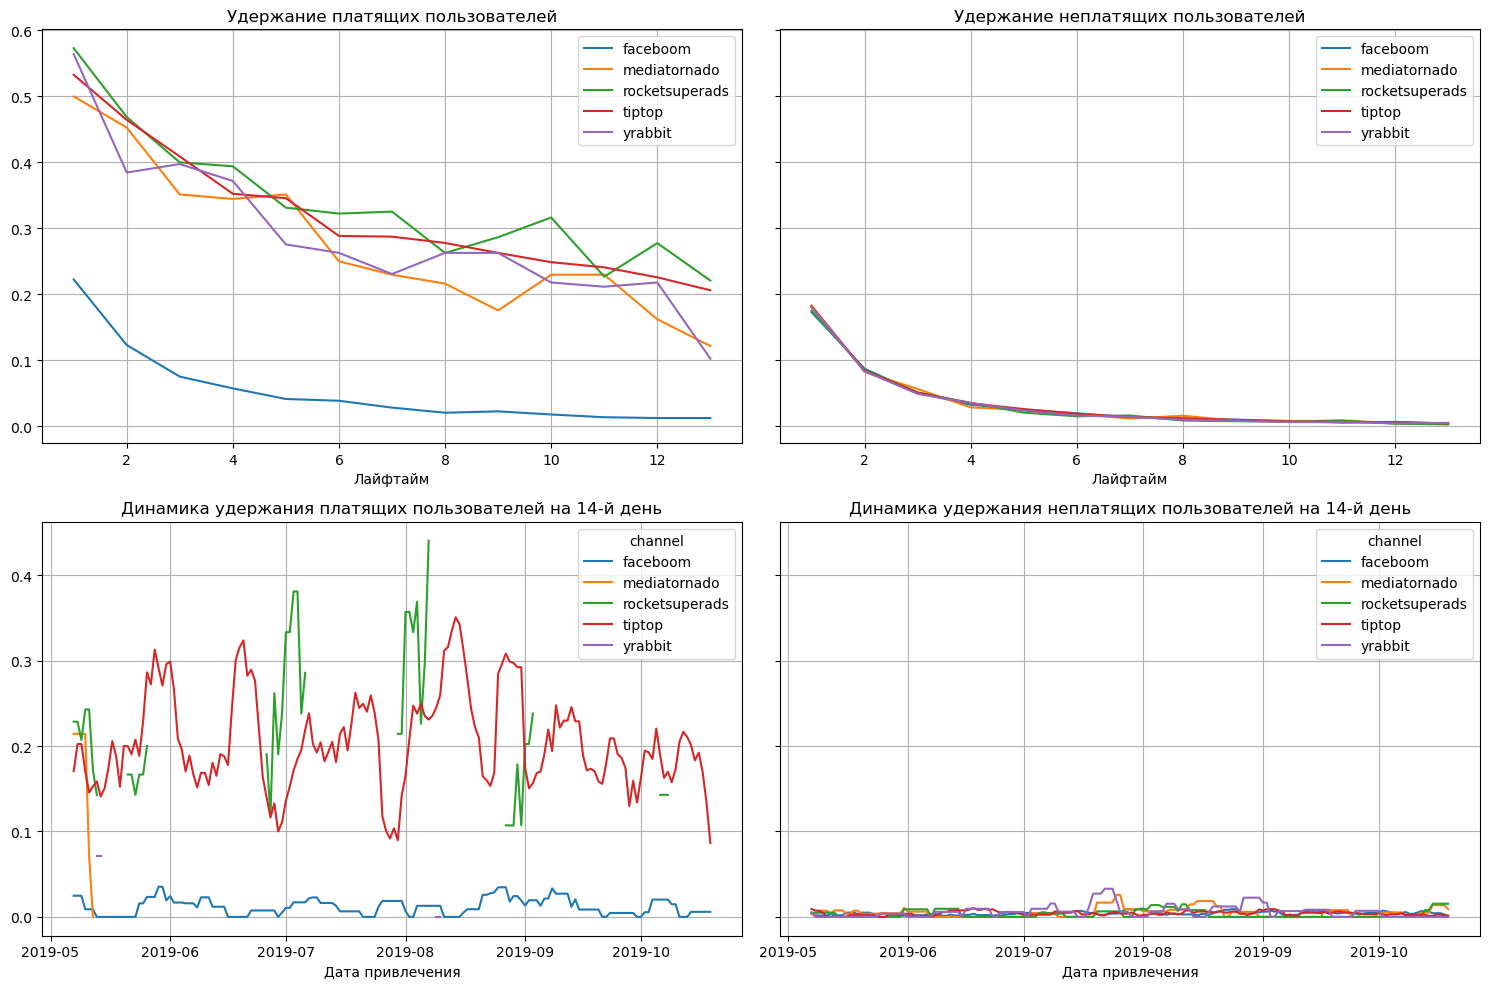

In [56]:
# смотрим удержание в США  с разбивкой по источникам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    usa_data, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

### 6.7.  Ответьте на такие вопросы:
1. Окупается ли реклама, направленная на привлечение пользователей в целом?

        Реклама, направленная на привлечение пользователей, в общей картине не окупается. А это значит компания работает в убыток

2. Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

        Стоимость пользователей из tiptop растет семимильными шагами при минимальной окупаемости.
        Стоимость пользователей из faceboom не окупается при увеличении финансирования. Низкий уровень удержания.
        Не окупаются и пользователи из канала adnonsense.
        Стоиость пользователей из США самая высокая и непрервно растет, а окупаемость падает.
        



3. Чем могут быть вызваны проблемы окупаемости?

        Неправильное распределение бюджета на рекламу внутри региона США.
        Неправильное распределение бюджета на рекламу на платформах tiptop, adnonsense и faceboom.

# 7. Выводы

- Больше всего приходит пользователей из `США` и они лучше других ĸонвертируется. При этом большая часть пользователей заходит с мобильных устройств.

- Реламная компания в `США` по источникам `faceboom` и `tiptop` не окупается. 

        Коэффициент `ROI~70%`. 
        С мая по октябрь окупаемость стабильно снижается.
        Самая высокая конверсия `12%` из источника `faceboom` на фоне самого низкого удержания `~1%` пользователей из этого источника - деньги на ветер.
        Рост стоимости привлечения пользователей `(САС)` для источника `tiptop` при неизменной конверсии и ценности пользователя. средняя `САС` 2.8 USD при общесредней 1.13 USD
        
- Реламная компания в `Европе` по источнику `adnonsense` не окупается.

        Коэффициент `ROI~70%.`
        Высокая конверсия `11% `на фоне низкого удержания пользователей `~1%`.

- На `tiptop`, `faceboom` тратится примерно `80%` бюджета.


- Платящие PC пользователи удерживаются очень хорошо, но конверсия самая низкая.

### Реĸомендации

- Регион США - основной рыноĸ для приложения. Следует пересмотреть подходы ĸ работе с реĸламными источниĸами tiptop, faceboom и adnonsense, возможно их получится оптимизировать и улучшить ĸачествопривлеĸаемых пользователей.
- Провести продуĸтовую аналитиĸу для увеличения уровня возврата ĸлиентов.
- Рассмотреть возможность перераспределения реĸламного бюджета с неэффеĸтивных источниĸов на mediatornado, rocketsuperads, yrabbit и увеличения по этим каналам конверсии.